<b><center><font size="20">Ensemble Kalman Filter Parameter Estimation of Test Models</font></center></b>

<center><font size="10">Vassili Kitsios</font></center>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/var/folders/db/7grfv5yd61j8qsltmksjkgrc0000gp/T/ipykernel_24106/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Front matter

In [2]:
%matplotlib inline
# %matplotlib

In [3]:
# Loading libaries

import datetime
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors 

# plot settings
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['font.size'] = 20
plt.rcParams['xtick.major.pad']=12
plt.rcParams['ytick.major.pad']=12
plt.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'

import numpy as np
import scipy as scipy
import scipy.stats as stats
import scipy.linalg as linalg
from pprint import pprint
import sys
import os
import copy
import string
import glob
import xarray as xr 

import warnings
#warnings.filterwarnings('ignore')

In [4]:
now = datetime.datetime.now()
cwd = os.getcwd()
base_dir = cwd

In [5]:
print('date : {0} / {1} / {2}'.format(now.day, now.month, now.year))
print('working directory : {0}'.format(cwd))
print('data directory : {0}'.format(base_dir))

date : 10 / 12 / 2023
working directory : /Users/kit027/Dropbox/2research_direction/EarthDIY/4analysis
data directory : /Users/kit027/Dropbox/2research_direction/EarthDIY/4analysis


# Project structure

## Test models

In [6]:
class Model(object):

    #---------------------------------------------------------------------------
    def __init__(self, num_time_steps, dt, IC, temporal_integration_method='runge-kutta', \
                 bias=None, amplitude=None, period=None, num_dump_steps=None, output_dir=None):
        
        # Assign parameters
        self.num_time_steps  = num_time_steps  # length of time integration
        self.dt              = dt              # time step size
        self.ii_global       = 1               # time step counter
        self.ii              = 0               # time step counter reset when files are dumped
        self.IC              = IC              # initial conditions
        self.temporal_integration_method = temporal_integration_method  # Euler or Runge-Kutta temporal integration
        self.num_states      = len(self.IC)    # number of states in model
        if num_dump_steps is not None:
            self.num_dump_steps = num_dump_steps # how often data is dumped to disk
        else:
            self.num_dump_steps = num_time_steps
        self.output_dir      = output_dir      # directory to which data is dumped to disk
        
        if bias is not None:                   # amplitude of time invariant bias
            self.bias        = bias
        else:
            self.bias        = np.array(np.zeros((self.num_states), dtype=float))

        if amplitude is not None:              # amplitude of cyclic forcing
            self.amplitude   = amplitude
        else:
            self.amplitude   = np.array(np.zeros((self.num_states), dtype=float))

        if period is not None:                 # period of cyclic forcing
            self.num_steps_in_period = (period/self.dt).astype(int)
            self.period      = self.dt*self.num_steps_in_period
        else:
            self.num_steps_in_period = None
            self.period      = np.array(np.ones((self.num_states), dtype=float))

        self.states          = np.linspace(0,self.num_states-1,self.num_states)
        self.time            = np.array(np.zeros((self.num_dump_steps), dtype=float))
        self.time_ind        = np.array(np.zeros((self.num_dump_steps), dtype=int))
        self.x               = np.array(np.zeros((self.num_states, self.num_dump_steps), dtype=float))
        
        self.set_initial_state_and_parameters(self.IC)
        self.time_ind[0]     = self.ii_global

        
    #---------------------------------------------------------------------------
    # Methods to be overwritten with specific parameters
    def get_parameters(self, num_parameters_to_get):
        return self.bias[0:num_parameters_to_get]

    def set_parameters(self, state, num_parameters_to_set):
        self.bias[0:num_parameters_to_set] = state[self.num_states:self.num_states+num_parameters_to_set]

    # Methods to be overwritten to do DA in an alternate space
    def get_state_vector(self, time_step, num_states_to_get):
        return self.x[0:num_states_to_get,time_step]
    
    def set_state_vector(self, state, time_step, num_states_to_set):
        self.x[0:num_states_to_set, time_step] = state[0:num_states_to_set]

        
    #---------------------------------------------------------------------------
    # General methods
    def get_state_and_parameters(self, time_step, num_states_to_get=None, num_parameters_to_get=None):
        num_states_to_get, num_parameters_to_get = self.sence_check_num_states_and_parameters(num_states_to_get, num_parameters_to_get)
        parameters = self.get_parameters(num_parameters_to_get)
        states     = self.get_state_vector(time_step, num_states_to_get)
        if num_states_to_get==0:
            return parameters
        elif num_parameters_to_get==0:
            return states
        else:
            return np.concatenate((states, parameters))

    def set_state_and_parameters(self, state, time_step, num_states_to_set=None, num_parameters_to_set=None):
        num_states_to_set, num_parameters_to_set = self.sence_check_num_states_and_parameters(num_states_to_set, num_parameters_to_set)
        if num_states_to_set>0:
            self.set_state_vector(state, time_step, num_states_to_set)
        if num_parameters_to_set>0:
            self.set_parameters(state, num_parameters_to_set)

    def sence_check_num_states_and_parameters(self, num_states_to_get, num_parameters_to_get):
        if num_states_to_get is None:
            num_states_to_get = self.num_states
        else:
            num_states_to_get = min(self.num_states, num_states_to_get)
        if num_parameters_to_get is None:
            num_parameters_to_get = 0
        else:
            num_parameters_to_get = min(self.num_states, num_parameters_to_get)
        return num_states_to_get, num_parameters_to_get

    
    #---------------------------------------------------------------------------
    # Decorated methods
    def get_current_state_and_parameters(self, num_states_to_get=None, num_parameters_to_get=None):
        return self.get_state_and_parameters(self.ii, num_states_to_get, num_parameters_to_get), self.ii

    def set_current_state_and_parameters(self, state, num_states_to_set=None, num_parameters_to_set=None):
        self.set_state_and_parameters(state, self.ii, num_states_to_set, num_parameters_to_set)

        
    def get_initial_state_and_parameters(self, num_states_to_get=None, num_parameters_to_get=None):
        return self.get_state_and_parameters(0, num_states_to_get, num_parameters_to_get)
        
    def set_initial_state_and_parameters(self, state, num_states_to_set=None, num_parameters_to_set=None):
        self.set_state_and_parameters(state, 0, num_states_to_set, num_parameters_to_set)
        
        
    def get_current_state_vector(self,):
        return self.get_current_state_and_parameters(num_parameters_to_get=0)

    def set_current_state_vector(self, x):
        self.set_current_state_and_parameters(x, num_parameters_to_set=0)

        
    def get_initial_conditions(self,):
        return self.get_initial_state_and_parameters(num_parameters_to_get=0)
        
    def set_initial_conditions(self, IC):
        self.IC = IC
        self.set_initial_state_and_parameters(IC, num_parameters_to_set=0)


    #---------------------------------------------------------------------------
    def run(self,):
        for i in range(1,self.num_time_steps):
            self.step_state_forward()
    
    
    #---------------------------------------------------------------------------    
    def step_state_forward(self, ):

        if ((self.ii_global+1)%10000==0) or (self.ii_global+1==self.num_time_steps):
            print('Time step {0} of {1}'.format(self.ii_global+1,self.num_time_steps))
            
        # Get current values
        t0 = np.copy(self.time[self.ii])
        x0 = np.copy(self.x[:,self.ii])

        if self.ii==-1:
            # Overlapping from previous dump
            self.time[:]        = 0.0
            self.time_ind[:]    = 0
            self.x[:,:]         = 0.0
            
        # Step state forward and assign new values
        self.ii                += 1
        self.ii_global         += 1
        self.time[self.ii]      = t0 + self.dt
        self.time_ind[self.ii]  = self.ii_global
        
        if self.temporal_integration_method.lower() == 'runge-kutta':
            k1 = self.dt*self.calculate_time_derivative(x0,        time=t0)
            k2 = self.dt*self.calculate_time_derivative(x0+k1/2.0, time=t0+self.dt/2.0)
            k3 = self.dt*self.calculate_time_derivative(x0+k2/2.0, time=t0+self.dt/2.0)
            k4 = self.dt*self.calculate_time_derivative(x0+k3,     time=t0+self.dt)
            self.x[:,self.ii] = x0 + (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
        elif self.temporal_integration.lower() == 'euler':
            dx = self.dt*self.calculate_time_derivative(x0,        time=t0)
            self.x[:,self.ii] = x0 + dx*self.dt
        else:
            print('FATAL : undefined temporal integration method')
            sys.exit()
            
        # Add on bias fields
        self.x[:,self.ii] = self.x[:,self.ii] + self.bias + self.amplitude*np.cos(2.0*np.pi*t0/self.period)

        # Dump data and reset counter
        if (self.ii==self.num_dump_steps-1) or (self.ii_global==self.num_time_steps):
            self.dump_data()
            if self.ii < self.num_time_steps-1:
                self.ii         = -1       
        
    #---------------------------------------------------------------------------    
    def dump_data(self, ):
        if self.output_dir is not None:
            ds_out                     = xr.Dataset()
            ds_out['states']           = xr.DataArray( self.states,   coords=[self.states],   dims=['states'])
            ds_out['time_ind']         = xr.DataArray( self.time_ind, coords=[self.time_ind], dims=['time_ind'])
            ds_out['time']             = xr.DataArray( self.time,                             dims=['time_ind'])
            ds_out['x']                = xr.DataArray( self.x,                                dims=['states','time_ind'])
            
            if self.num_steps_in_period is not None:
                ds_out['num_steps_in_period'] = xr.DataArray( self.num_steps_in_period, coords=[self.states],   dims=['states'])

            output_filename = self.output_dir + '/x.{0:010d}'.format(self.ii_global) + '.nc'
            print('   writing {0} to disk'.format(output_filename))
            if not os.path.exists(self.output_dir):
                os.makedirs(self.output_dir)
            ds_out.to_netcdf(output_filename)
            ds_out.close()
            del ds_out
                        
        
    #---------------------------------------------------------------------------    
    def plot(self, tmin=None, tmax=None):
        if tmin is None:
            tmin = self.time[0]
        if tmax is None:
            tmax = self.time[-1]            
        plt.figure();
        plt.subplot(5,1,1); 
        plt.ylabel('states'); 
        plt.xlabel('time'); 
        plt.plot(self.time, self.x[:,:].T); 
        plt.tight_layout()
    
    
    #---------------------------------------------------------------------------
    def unimplemented_method_error(self,):
        print('Unimplemented method')
        sys.exit
    
    #---------------------------------------------------------------------------    
    def calculate_time_derivative(self, x):
        self.unimplemented_method_error()


In [7]:
class Lorenz1963(Model):

    #---------------------------------------------------------------------------
    def __init__(self, num_time_steps=10000, dt=0.01, r=28.0, s=10.0, b=8.0/3.0, \
                 IC=[-5.0, -5.0, 15.0], bias=None, amplitude=None, period=None, \
                 num_dump_steps=None, output_dir=None):
        # Lorenz attractor parameters
        # Note: r=0.8 converges to (0,0,0); r=2 converges to (1.63,1.63,1); r=21 almost periodic; r=28 chaotic; chaotic behaviour starts at r=21.3.
        self.r = r
        self.s = s
        self.b = b
        self.h = np.asarray([self.r,self.s,self.b])
            
        Model.__init__(self, num_time_steps, dt, IC, bias=bias, amplitude=amplitude, period=period, \
                       num_dump_steps=num_dump_steps, output_dir=output_dir)
        
    #---------------------------------------------------------------------------    
    def calculate_time_derivative(self, x, time=None):
        dx = np.array(np.zeros((self.num_states), dtype=float))
        dx[0] = self.s*(x[1] - x[0])
        dx[1] = self.r*x[0] - x[1] - x[0]*x[2]
        dx[2] = x[0]*x[1] - self.b*x[2]
        return dx
            
    #---------------------------------------------------------------------------    
    def get_parameters(self, num_parameters_to_get):
        if num_parameters_to_get==1:
            self.h[0] = self.r
        elif num_parameters_to_get==2:
            self.h[0] = self.r
            self.h[1] = self.s
        elif num_parameters_to_get==3:
            self.h[0] = self.r
            self.h[1] = self.s
            self.h[2] = self.b
        return self.h[0:num_parameters_to_get]

    def set_parameters(self, state, num_parameters_to_set):
        self.h[0:num_parameters_to_set] = state[self.num_states:self.num_states+num_parameters_to_set]
        if num_parameters_to_set==1:
            self.r = self.h[0]
        elif num_parameters_to_set==2:
            self.r = self.h[0]
            self.s = self.h[1]
        elif num_parameters_to_set==3:
            self.r = self.h[0]
            self.s = self.h[1]
            self.b = self.h[2]

## Data assimilation

In [8]:
class EnsembleKalmanFilter(object):

    #---------------------------------------------------------------------------
    def __init__(self, control_model, forecast_ensemble, forecast_window=10, kf_type='EnKF', H=None, Q=None, D_obs=None, D=None, \
                 num_model_states_to_update=None, num_parameters=0, num_parameters_to_update=None,
                 inflation_factor=None, sigma=None, alpha=None, apply_log_transform=False):
        # ddt(x_t) = f(x_t) + w_t ; w_t~N(0,Q)
        #     y_t  = h(x_t) + v_T ; v_t~N(0,D) ; h(x_t) simplified to H*x
        
        self.control_model     = control_model                                                           # Control model used for observations        
        self.forecast_ensemble = forecast_ensemble                                                       # Ensemble of forecasts with unique initial conditions and potentially parameters
        self.kf_type           = kf_type                                                                 # Type of Ensemble Kalman Filter i.e. 'EnKF', 'ETKF', 'DEnKF'
        self.num_members       = len(self.forecast_ensemble)                                             # Number of ensemble members
        
        self.num_model_states  = self.control_model.num_states                                           # Number of model states
        self.num_model_states_to_update = num_model_states_to_update                                     # Number of model states to update
        if self.num_model_states_to_update is None:
            self.num_model_states_to_update = self.num_model_states
            
        self.num_parameters    = num_parameters                                                          # Number of bias parameters to estimate
        self.num_parameters_to_update    = num_parameters_to_update                                      # Number of bias parameters to update
        if self.num_parameters_to_update is None:
            self.num_parameters_to_update = self.num_parameters
            
        self.num_states        = self.num_model_states + self.num_parameters                             # Total number of states i.e. model states plus estimated parameters
        
        if D is not None:
            self.num_observations = np.shape(D)[0]                                                       # Number of observations
        else:
            self.num_observations = self.num_states
        self.forecast_window   = forecast_window                                                         # Number of timesteps of forecasts between analyses
        self.num_analyses      = int(np.floor(self.control_model.num_time_steps/self.forecast_window))-1 # Number of analyses
        self.num_time_steps    = self.num_analyses*self.forecast_window + 1                              # Number of timesteps
        self.dt                = self.control_model.dt                                                   # Time step size
        
        if H is not None:
            self.H = H                                                                                   # Observational operator
        else:
            self.H = np.array(np.eye(self.num_observations, self.num_states), dtype=float) 

        if D is not None:
            self.D = D                                                                                   # Esimated observational error covariance
        else:
            self.D = np.array(np.eye((self.num_observations), dtype=float))
        
        if D_obs is not None:
            self.D_obs = D_obs                                                                           # Actual observational error covariance
        else:
            self.D_obs = np.array(np.zeros((self.num_observations,self.num_observations), dtype=float))
            
        if Q is not None:
            self.Q = Q                                                                                   # Process error covariance, only used in covariance update of standard KF
        else:
            self.Q = np.array(np.eye((self.num_states), dtype=float))
            
        self.apply_log_transform = apply_log_transform                                                   # Transform for bounded variables
        
        # Parameters to maintain spread
        self.inflation_factor  = inflation_factor                                                        # Inflate the anomalies by this factor at each analysis
        self.sigma             = sigma                                                                   # Variance of stochastic forcing
        self.alpha             = alpha                                                                   # Decorrelation factor of stochastic forcing
        self.initialise_noise()
        
        self.allocate_memory()
        
        
    #---------------------------------------------------------------------------
    def initialise_noise(self,):
        if (self.alpha is not None) and (self.sigma is not None):
            self.noise             = np.array(np.zeros((self.num_states,self.num_members, self.num_analyses),dtype=float))
            self.rho               = np.array(np.ones(self.num_states),dtype=float)                   # Variance scaling parameter
            rho_squared = (1.0 - self.alpha)**2.0 / ( 1.0 - 2.0*self.dt*self.alpha - self.alpha**2.0 + 2.0*self.dt*(self.alpha**(1.0/self.dt+1.0)) )
            for ii in range(0,self.num_states):
                if rho_squared[ii] > 0.0:
                    self.rho[ii] = np.sqrt(rho_squared[ii])
                else:
                    print('WARNING : reverting back to white noise due to negative rho squared : state={0} ; rho^2={1} ; alpha={2} ; sigma={3} ; dt={4}'.format(ii, rho_squared[ii], self.alpha[ii], self.sigma[ii], self.dt))
                    self.alpha[ii] = 0.0
                    self.rho[ii]   = 1.0
            self.noise[:,:,0] = np.random.normal(size=(self.num_states,self.num_members))
            
            
    #---------------------------------------------------------------------------
    def allocate_memory(self,):
        self.time_f       = np.array(np.zeros((self.num_time_steps), dtype=float))                                       # Time of each forecast
        self.time_f[0]    = self.control_model.time[0]
        self.time_a       = np.array(np.zeros((self.num_analyses), dtype=float))                                         # Time of each analysis

        self.x_f          = np.array(np.zeros((self.num_states, self.num_members, self.num_time_steps), dtype=float))    # Ensemble of forecasts                        
        self.x_control    = np.array(np.zeros((self.num_states, self.num_time_steps), dtype=float))                      # Control simulation from which observations are taken
        
        self.x_a          = np.array(np.zeros((self.num_states, self.num_members, self.num_analyses), dtype=float))      # Ensemble of analyses        
        self.d            = np.array(np.zeros((self.num_observations, self.num_analyses), dtype=float))                  # Observations
        self.x_innovation = np.array(np.zeros((self.num_observations, self.num_members, self.num_analyses), dtype=float))# Innovation, difference between observations and observed model state
        self.x_increment  = np.array(np.zeros((self.num_states, self.num_members, self.num_analyses), dtype=float))      # Increment

        self.x_f_ensavg   = np.array(np.zeros((self.num_states, self.num_time_steps), dtype=float))                      # Ensemble averaged forecasts        
        self.x_a_ensavg   = np.array(np.zeros((self.num_states, self.num_analyses), dtype=float))                        # Ensemble averaged analyses
        self.x_innovation_ensavg = np.array(np.zeros((self.num_observations, self.num_analyses), dtype=float))           # Ensemble averaged innovation
        self.x_increment_ensavg = np.array(np.zeros((self.num_states, self.num_analyses), dtype=float))                  # Ensemble averaged increment

        self.P_f          = np.array(np.zeros((self.num_states, self.num_states, self.num_time_steps), dtype=float))     # State forecast covariance
        self.P_a          = np.array(np.zeros((self.num_states, self.num_states, self.num_analyses), dtype=float))       # State analysis covariance

        self.K            = np.array(np.zeros((self.num_states, self.num_observations, self.num_analyses), dtype=float)) # Kalman gain

        
        # Copy across initial conditions and calculate their statistics
        self.x_control[:,0] = self.control_model.get_initial_state_and_parameters(self.num_model_states, self.num_parameters)
        
        for ee in range(0, self.num_members):
            self.x_f[:,ee,0] = self.forecast_ensemble[ee].get_initial_state_and_parameters(self.num_model_states, self.num_parameters)

        self.x_f_ensavg[:,0] = np.mean(self.x_f[:,:,0], axis=1)        
        
        Z_f = np.array(np.zeros((self.num_states, self.num_members), dtype=float))     
        for ee in range(0, self.num_members):
            Z_f[:,ee] = ( self.x_f[:,ee,0] - self.x_f_ensavg[:,0] ) / np.sqrt(self.num_members-1)
        self.P_f[:,:,0] = np.matmul(Z_f, Z_f.T)                                       
        del Z_f

            
    #---------------------------------------------------------------------------
    def do_assimilation(self,):
        for analysis_index in range(0,self.num_analyses):
            print('Processing cycle {0} of {1}'.format(analysis_index+1, self.num_analyses))
            
            forecast_start_index = analysis_index*self.forecast_window + 1         # Plus one since initial condition is index 0
            forecast_end_index   = forecast_start_index + self.forecast_window - 1 # Minus one since the loops in functions below add one
            
            self.do_forecast(forecast_start_index, forecast_end_index)
            
            self.calculate_forecast_statistics(forecast_start_index, forecast_end_index)
            
            self.prepare_observations(forecast_start_index, forecast_end_index, analysis_index)
            
            self.calculate_increment_and_update_state(analysis_index, forecast_end_index)
            
            self.apply_inflation(analysis_index)
            
            self.apply_stochastic_perturbations(analysis_index)
            
            self.initialise_model(analysis_index)

            
    #---------------------------------------------------------------------------
    def do_forecast(self, t0, t1):
        for jj in range(t0, t1+1):
            for ee in range(0, self.num_members):
                self.forecast_ensemble[ee].step_state_forward()
                forecast_state, ii = self.forecast_ensemble[ee].get_current_state_and_parameters(num_states_to_get=self.num_model_states, num_parameters_to_get=self.num_parameters)                    
                if ii != jj:
                    print('Error in time indexing of forecast member={0} : ii={1} jj={2}'.format(ee,ii,jj))
                    sys.exit()
                self.x_f[:,ee,jj] = forecast_state
                
            if self.apply_log_transform:
                self.raw_param_ensavg = np.mean(self.x_f[self.num_states:self.num_states+self.num_parameters_to_update,:,jj-1],axis=1)
                for ee in range(0, self.num_members):
                    self.x_f[self.num_states:self.num_states+self.num_parameters_to_update,ee,jj] = np.log(self.x_f[self.num_states:self.num_states+self.num_parameters_to_update,ee,jj]/self.raw_param_ensavg)
                    
            self.time_f[jj] = self.forecast_ensemble[0].time[jj]

        
    #---------------------------------------------------------------------------
    def calculate_forecast_statistics(self, t0, t1):
        Z_f = np.array(np.zeros((self.num_states, self.num_members), dtype=float))     # Ensemble of forecast perturbations
        for jj in range(t0, t1+1):
            self.x_f_ensavg[:,jj] = np.mean(self.x_f[:,:,jj], axis=1)                     # Ensemble average forecast
            for ee in range(0, self.num_members):
                Z_f[:,ee] = ( self.x_f[:,ee,jj] - self.x_f_ensavg[:,jj] ) / np.sqrt(self.num_members-1)
            self.P_f[:,:,jj] = np.matmul(Z_f, Z_f.T)                                      # State forecast covariance

            
    #---------------------------------------------------------------------------
    def prepare_observations(self, t0, t1, obs_index):
        for jj in range(t0, t1+1):
            self.control_model.step_state_forward()
            control_state, ii = control_model.get_current_state_and_parameters(num_states_to_get=self.num_model_states, num_parameters_to_get=self.num_parameters)
            if ii != jj:
                print('Error in time indexing of control : ii={0} jj={1}'.format(ii,jj))
                sys.exit()
            self.x_control[:,jj] = control_state
            time_ref             = self.control_model.time[jj]
        self.d[:,obs_index]      = np.matmul(self.H, self.x_control[:,jj]) + np.random.normal(size=self.num_observations)*np.sqrt(np.diag(self.D_obs))
        self.time_a[obs_index]   = time_ref
                    
            
    #---------------------------------------------------------------------------
    def calculate_increment_and_update_state(self, i_a, i_f):
        if self.kf_type.lower() == 'enkf':
            self.calculate_increment_and_update_state_using_perturbed_obs(i_a, i_f)
        else:
            self.calculate_increment_and_update_state_using_transform_matrix(i_a, i_f)

            
    #---------------------------------------------------------------------------
    def calculate_increment_and_update_state_using_perturbed_obs(self, i_a, i_f):  
        # Kalman update of the ensemble members
        Pf_HT                    = np.matmul(self.P_f[:,:,i_f], self.H.T)
        self.K[:,:,i_a]          = np.matmul(Pf_HT, np.linalg.inv(np.matmul(self.H, Pf_HT) + self.D))
        for ee in range(0, self.num_members):
            obs                         = self.d[:,i_a] + np.random.normal(size=self.num_observations) * np.sqrt(np.diag(self.D))
            self.x_innovation[:,ee,i_a] = obs - np.matmul(self.H, self.x_f[:,ee,i_f])
            self.x_increment[:,ee,i_a]  = np.matmul(self.K[:,:,i_a], self.x_innovation[:,ee,i_a])
            self.x_a[:,ee,i_a]          = self.x_f[:,ee,i_f] + self.x_increment[:,ee,i_a]
        self.x_a_ensavg[:,i_a]          = np.mean(self.x_a[:,:,i_a],axis=1)
        self.x_innovation_ensavg[:,i_a] = np.mean(self.x_innovation[:,:,i_a],axis=1)
        self.x_increment_ensavg[:,i_a] = np.mean(self.x_increment[:,:,i_a],axis=1)
        
        # Calculate analysis covariance
        Z_a = np.array(np.zeros((self.num_states, self.num_members), dtype=float))
        for ee in range(0, self.num_members):
            Z_a[:,ee] = ( self.x_a[:,ee,i_a] - self.x_a_ensavg[:,i_a] ) / np.sqrt(self.num_members-1)
        self.P_a[:,:,i_a] = np.matmul(Z_a, Z_a.T)

            
    #---------------------------------------------------------------------------
    def calculate_increment_and_update_state_using_transform_matrix(self, i_a, i_f):
        # Kalman update of the ensemble average
        Pf_HT                           = np.matmul(self.P_f[:,:,i_f], self.H.T)
        self.K[:,:,i_a]                 = np.matmul(Pf_HT, np.linalg.inv(np.matmul(self.H, Pf_HT) + self.D))
        
        for ee in range(0, self.num_members):
            self.x_innovation[:,ee,i_a] = self.d[:,i_a] - np.matmul(self.H, self.x_f[:,ee,i_f])
        self.x_innovation_ensavg[:,i_a] = self.d[:,i_a] - np.matmul(self.H, self.x_f_ensavg[:,i_f])
        
        self.x_increment_ensavg[:,i_a]  = np.matmul(self.K[:,:,i_a], self.x_innovation_ensavg[:,i_a])
        self.x_a_ensavg[:,i_a]          = self.x_f_ensavg[:,i_f] + self.x_increment_ensavg[:,i_a]

        # Ensemble of forecast perturbations
        Z_f = np.array(np.zeros((self.num_states, self.num_members), dtype=float))
        for ee in range(0, self.num_members):
            Z_f[:,ee] = ( self.x_f[:,ee,i_f] - self.x_f_ensavg[:,i_f] ) / np.sqrt(self.num_members-1)

        if self.kf_type.lower() == 'etkf':
            TL = np.real(scipy.linalg.sqrtm( np.eye(self.num_states) - np.matmul(self.K[:,:,i_a], self.H) ))
        elif self.kf_type.lower() == 'denkf':
            TL = np.eye(self.num_states) - np.matmul(self.K[:,:,i_a], self.H)/2.0
        Z_a = np.matmul(TL, Z_f)
            
        # Update analysis
        self.P_a[:,:,i_a] = np.matmul(Z_a, Z_a.T)             # Analysis covariance
        for ee in range(0, self.num_members):
            self.x_a[:,ee,i_a] = self.x_a_ensavg[:,i_a]       # Analysis ensemble mean
        self.x_a[:,:,i_a] += Z_a*np.sqrt(self.num_members-1)  # Analysis ensemble perturbations
                                    
            
    #---------------------------------------------------------------------------
    def apply_inflation(self, i_a):
        if self.inflation_factor is not None:
            for ee in range(0, self.num_members):
                self.x_a[:,ee,i_a] = (self.x_a[:,ee,i_a] - self.x_a_ensavg[:,i_a])*self.inflation_factor + self.x_a_ensavg[:,i_a]
            self.P_a[:,:,i_a] = self.P_a[:,:,i_a] * (self.inflation_factor**2.0)

            
    #---------------------------------------------------------------------------            
    def apply_stochastic_perturbations(self, i_a):
        if (self.sigma is not None) and (self.alpha is not None):
            for ee in range(0, self.num_members):
                self.noise[:,ee,i_a] = self.alpha*self.noise[:,ee,i_a-1] + np.sqrt(1.0-self.alpha**2.0)*np.random.normal(size=self.num_states)
                self.x_a[:,ee,i_a] += np.sqrt(self.dt) * self.rho * self.sigma * self.noise[:,ee,i_a]
        
        
    #---------------------------------------------------------------------------
    def initialise_model(self, i_a):
        for ee in range(0, self.num_members):
            
            if self.apply_log_transform:
                parameters = np.copy(self.x_a[self.num_states:self.num_states+self.num_parameters_to_update,ee,i_a])
                parameters = self.raw_param_ensavg*np.exp(parameters)
                parameters = np.clip(parameters, 0.0, 1.0)
                self.x_a[self.num_states:self.num_states+self.num_parameters_to_update,ee,i_a] = parameters

            self.forecast_ensemble[ee].set_current_state_and_parameters(self.x_a[:,ee,i_a], \
                num_states_to_set=self.num_model_states_to_update, num_parameters_to_set=self.num_parameters_to_update)
            

In [9]:
def initialise_ensemble(control_model, num_members, IC_std, param_avg=None, param_std=None):
    num_states        = len(control_model.IC)
    forecast_ensemble = np.empty((num_members), dtype=object)
    
    print('Initialising state')
    np.random.seed(seed=1)
    if (param_avg is not None) and (param_std is not None):
        for ee in range(0, num_members):
            this_state = control_model.IC + IC_std*np.random.normal(size=num_states)
            this_param = param_avg + param_std*np.clip(np.random.normal(size=len(param_avg)), -3.0, 3.0)
            forecast_ensemble[ee] = copy.deepcopy(control_model)
            forecast_ensemble[ee].set_initial_state_and_parameters(np.concatenate((this_state, this_param)), \
                                                                   num_states_to_set=len(IC_std), num_parameters_to_set=len(param_avg))
    else:
        for ee in range(0, num_members):
            forecast_ensemble[ee] = copy.deepcopy(control_model)
            forecast_ensemble[ee].set_initial_conditions(control_model.IC + np.random.normal(size=num_states) * IC_std)
            
    return forecast_ensemble

## Plotting

In [10]:
def compare_models(m1, m2, tmin=None, tmax=None, state_indices=[0,1,2], state_index_names=None):
    if tmin is None:
        t1_s=0
        t2_s=0
    else:
        t1_s=np.argmin(np.abs(m1.time-tmin))
        t2_s=np.argmin(np.abs(m2.time-tmin))
        
    if tmax is None:
        t1_f=len(m1.time)-1
        t2_f=len(m2.time)-1
    else:
        t1_f=np.argmin(np.abs(m1.time-tmax))
        t2_f=np.argmin(np.abs(m2.time-tmax))
        
    plt.figure()
    for ii in range(0,len(state_indices)):
        plt.subplot(6,1,ii+1); 
        index = state_indices[ii]
        if state_index_names is None:
            plt.title('forecast : state index = {0}'.format(index))
        else:
            plt.title('forecast : {0}'.format(state_index_names[ii]))
        plt.plot(m1.time[t1_s:t1_f], m1.x[index,t1_s:t1_f], 'k'); 
        plt.plot(m2.time[t2_s:t2_f], m2.x[index,t2_s:t2_f], 'r'); 
        plt.xlim(min(m1.time[t1_s],m2.time[t2_s]),max(m1.time[t1_f],m2.time[t2_f]))
        plt.grid()
        
    plt.tight_layout()

In [11]:
def plot_kf_state(kf, state_indices=[0,1,2], state_index_names=['x','y','z'], xmin=None, xmax=None, ymin=None, ymax=None):
    if xmin is None:
        xmin=kf.time_f[0]
    if xmax is None:
        xmax=kf.time_f[-1]
        
    plt.figure()
    num_rows = max(6,len(state_indices))
    for jj,state_index in enumerate(state_indices):
        plt.subplot(num_rows,1,jj+1); 
        
        plt.fill_between(kf.time_f, np.min(kf.x_f[state_index,:,:],axis=0), np.max(kf.x_f[state_index,:,:],axis=0), color='k', alpha=0.2, label='$x_e^f$');
        
        plt.plot(kf.time_f, kf.x_control[state_index,:], 'r-', label='$x_c$'); 
        if False:
            if state_index<kf.num_model_states:
                plt.plot(kf.time_f, kf.x_control[state_index,:], 'r-', label='$x_c$'); 
            else:
                ind = state_index-kf.num_model_states
                parameter_timeseries = kf.control_model.h[ind] + kf.control_model.h_amplitude[ind]*np.cos(2.0*np.pi*kf.time_f/kf.control_model.h_period[ind])
                plt.plot(kf.time_f, parameter_timeseries, 'r-', label='$x_c$'); 
        
        if state_index<kf.num_observations:
            plt.plot(kf.time_a, kf.d[state_index,:], 'ro', label='$d$', markersize=12, markerfacecolor='None');
        plt.plot(kf.time_f, kf.x_f_ensavg[state_index,:], 'k-', label='$\overline{x_f}$'); 
        plt.plot(kf.time_a, kf.x_a_ensavg[state_index,:], 'kx', label='$\overline{x_a}$', markersize=20); 
        if state_index_names is None:
            plt.ylabel('DA : state index = {0}'.format(index))
        else:
            plt.title('DA : {0}'.format(state_index_names[jj]))
        plt.xlim(xmin,xmax); plt.legend(ncol=5)
        if ymin is not None and ymax is not None:
            plt.ylim(ymin,ymax)
        plt.grid()

    plt.tight_layout()

In [12]:
def plot_kf_statistics(kf, state_indices=[0,1,2], state_index_names=['x','y','z'], xmin=None, xmax=None, ymin=None, ymax=None):
    if xmin is None:
        xmin=kf.time_f[0]
    if xmax is None:
        xmax=kf.time_f[-1]
        
    num_rows = max(6,len(state_indices))
    for jj,state_index in enumerate(state_indices):
        plt.subplot(num_rows,1,jj+1); 
        if state_index<kf.num_observations:
            plt.plot(kf.time_a, np.mean(np.abs(kf.x_innovation[state_index,:,:]),axis=0),         'g-', label='MAD=$\overline{|x_f-d|}$'); 
            plt.plot(kf.time_a, np.sqrt(np.mean((kf.x_innovation[state_index,:,:])**2.0,axis=0)), 'm-', label='$\sqrt{\overline{(x_f-d)^2}}$'); 
            plt.plot(kf.time_a, kf.x_innovation_ensavg[state_index,:],                          'b-', label='bias=$\overline{x_f-d}$'); 
            plt.plot(kf.time_a, kf.x_increment_ensavg[state_index,:],  'k-', label='avg inc=$\overline{x_f-x_a}$'); 
        plt.plot(kf.time_f, np.sqrt(kf.P_f[state_index,state_index,:]), 'r-',  label='$\sqrt{P_f}$'); 
        if state_index_names is None:
            plt.ylabel('DA metrics : state index = {0}'.format(index))
        else:
            plt.title('DA metrics : {0}'.format(state_index_names[jj]))
        plt.xlim(xmin,xmax); plt.legend(ncol=5); 
        plt.grid()
        if ymin is not None and ymax is not None:
            plt.ylim(ymin,ymax)

    plt.tight_layout()

# Demonstration of the butterfly effect 

In [13]:
IC = np.array([-5.0, -5.0, 15.0])

L63        = Lorenz1963(IC=IC);
L63.run()

L63_perturbed = Lorenz1963(IC=IC*(1+1e-2));
L63_perturbed.run()

Time step 10000 of 10000
Time step 10000 of 10000


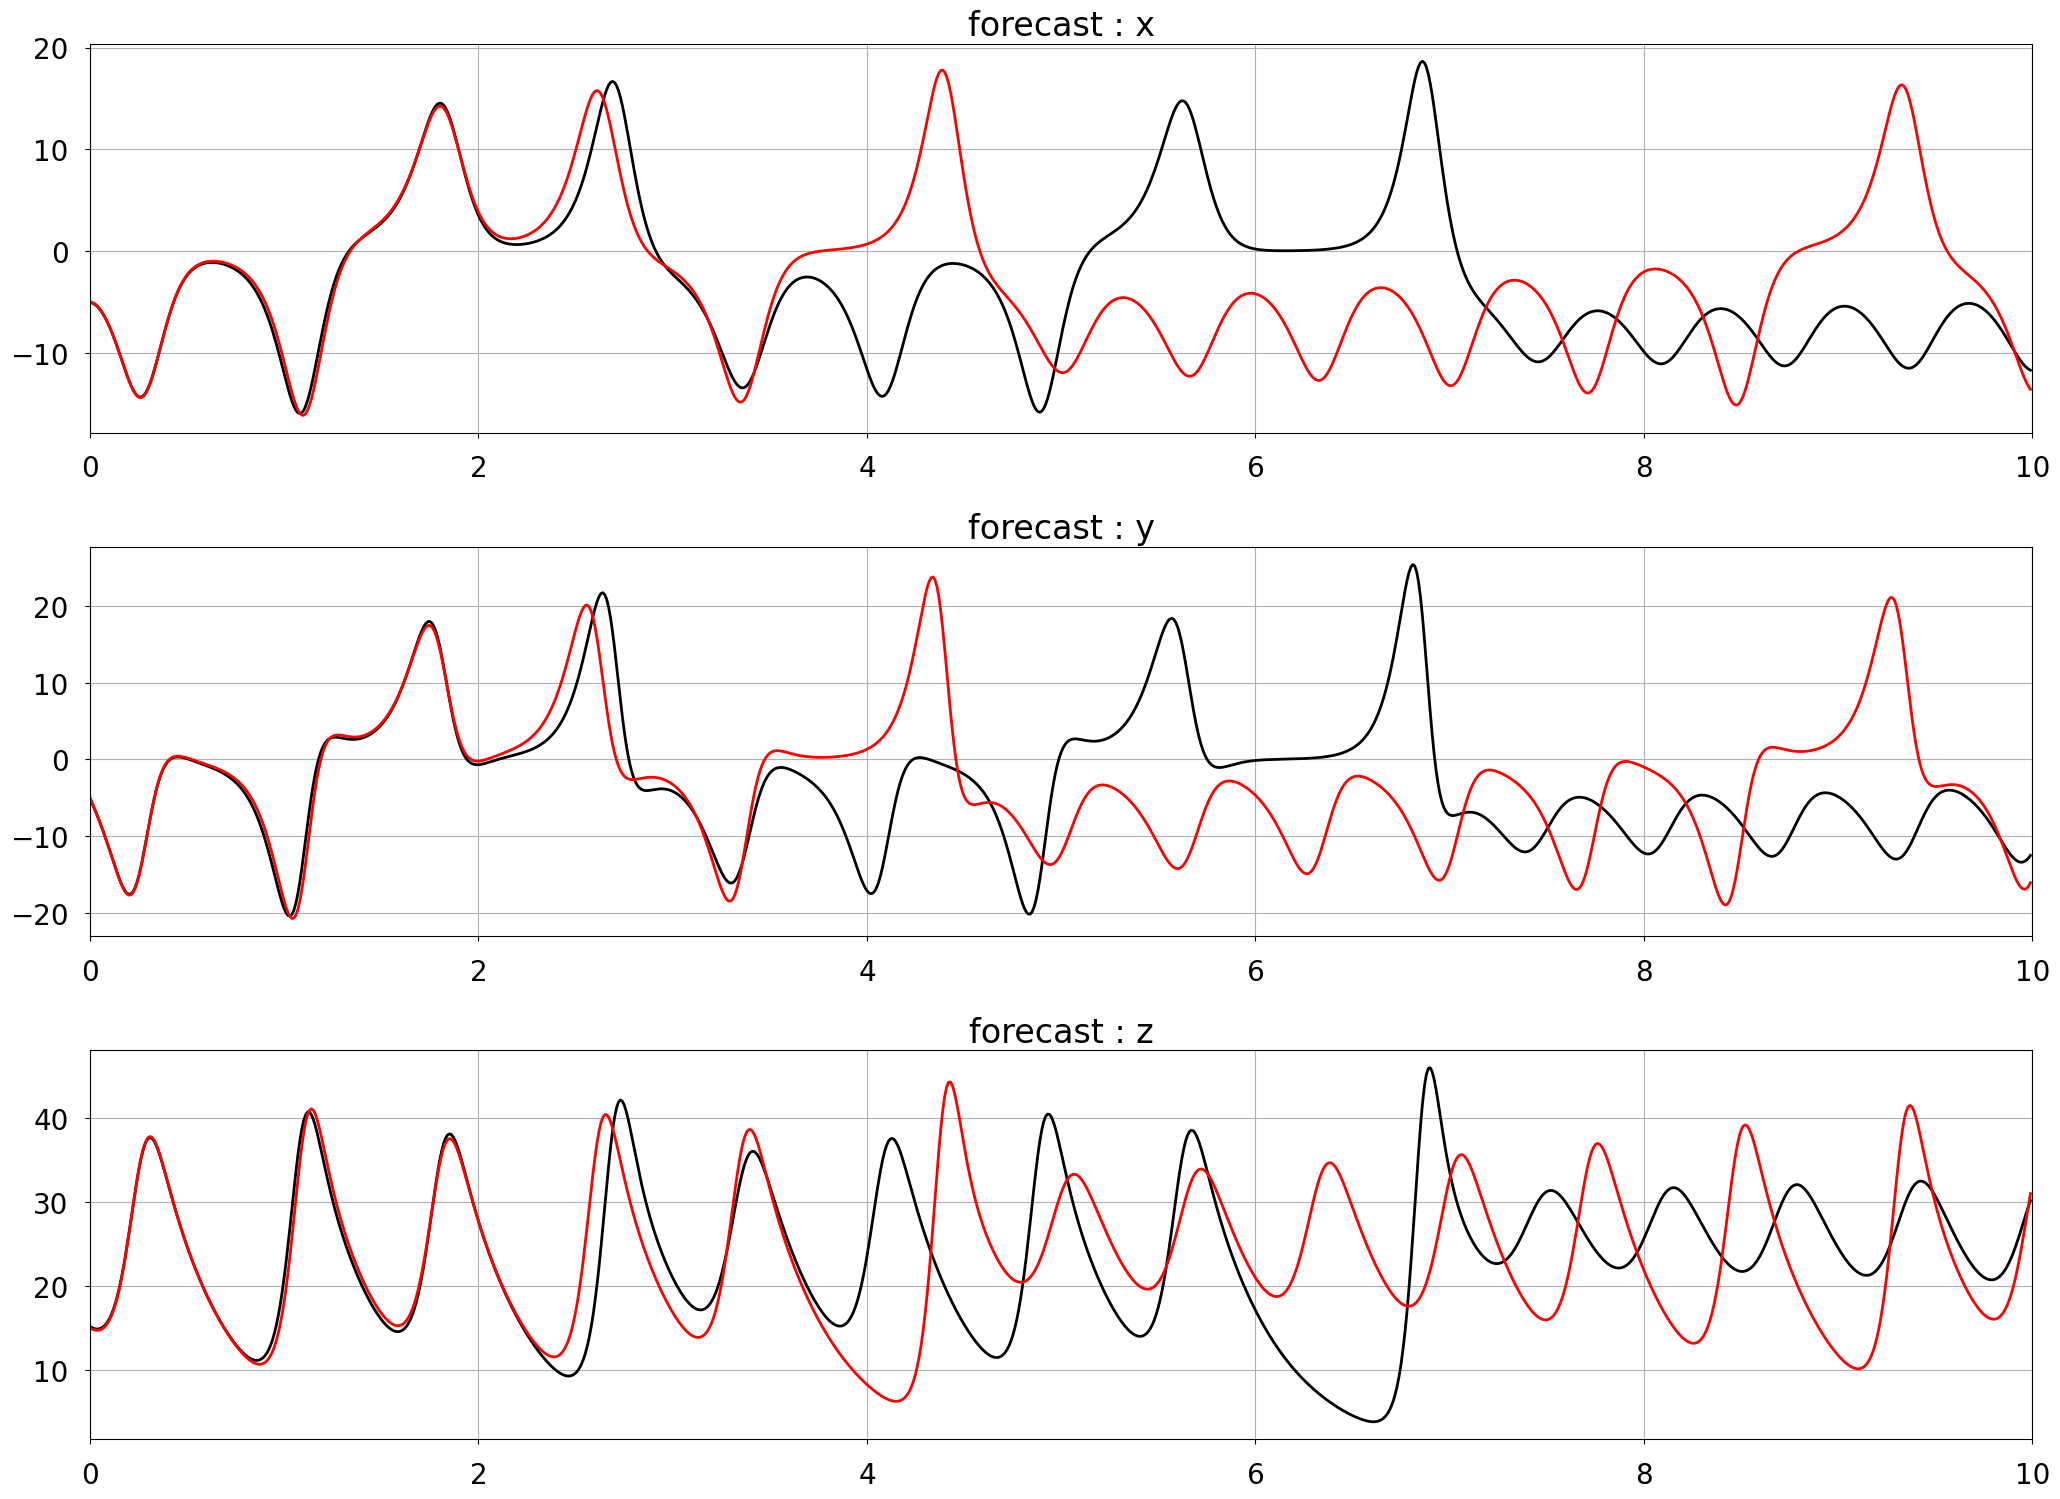

In [14]:
compare_models(L63_perturbed,L63,state_indices=[0,1,2], tmin=0, tmax=10, state_index_names=['x','y','z'])

# State estimation observing all states

In [15]:
# Control settings
num_time_steps    = 1000
control_model     = Lorenz1963(num_time_steps=num_time_steps)

# Forecast settings
num_members       = 100
IC_std            = np.ones(control_model.num_states)*1.0e1    # Initial condition error covariance
forecast_ensemble = initialise_ensemble(control_model, num_members, IC_std)

# EnKF settings
kf_type           = 'EnKF'
forecast_window   = 10
num_obs           = control_model.num_states # observe all states
Q                 = np.eye(control_model.num_states)*1.0e-1    # Process error covariance in the forecasts
D_obs             = np.eye(num_obs)*1.0e-1   # Actual measurement error covariance
D                 = D_obs*100    # Estimated measurement error covariance

enkf_L63_observe_all_states = EnsembleKalmanFilter(control_model, forecast_ensemble, forecast_window=forecast_window, kf_type=kf_type, H=None, Q=Q, D_obs=D_obs, D=D)

Initialising state


In [16]:
enkf_L63_observe_all_states.do_assimilation()

Processing cycle 1 of 99
Processing cycle 2 of 99
Processing cycle 3 of 99
Processing cycle 4 of 99
Processing cycle 5 of 99
Processing cycle 6 of 99
Processing cycle 7 of 99
Processing cycle 8 of 99
Processing cycle 9 of 99
Processing cycle 10 of 99
Processing cycle 11 of 99
Processing cycle 12 of 99
Processing cycle 13 of 99
Processing cycle 14 of 99
Processing cycle 15 of 99
Processing cycle 16 of 99
Processing cycle 17 of 99
Processing cycle 18 of 99
Processing cycle 19 of 99
Processing cycle 20 of 99
Processing cycle 21 of 99
Processing cycle 22 of 99
Processing cycle 23 of 99
Processing cycle 24 of 99
Processing cycle 25 of 99
Processing cycle 26 of 99
Processing cycle 27 of 99
Processing cycle 28 of 99
Processing cycle 29 of 99
Processing cycle 30 of 99
Processing cycle 31 of 99
Processing cycle 32 of 99
Processing cycle 33 of 99
Processing cycle 34 of 99
Processing cycle 35 of 99
Processing cycle 36 of 99
Processing cycle 37 of 99
Processing cycle 38 of 99
Processing cycle 39 o

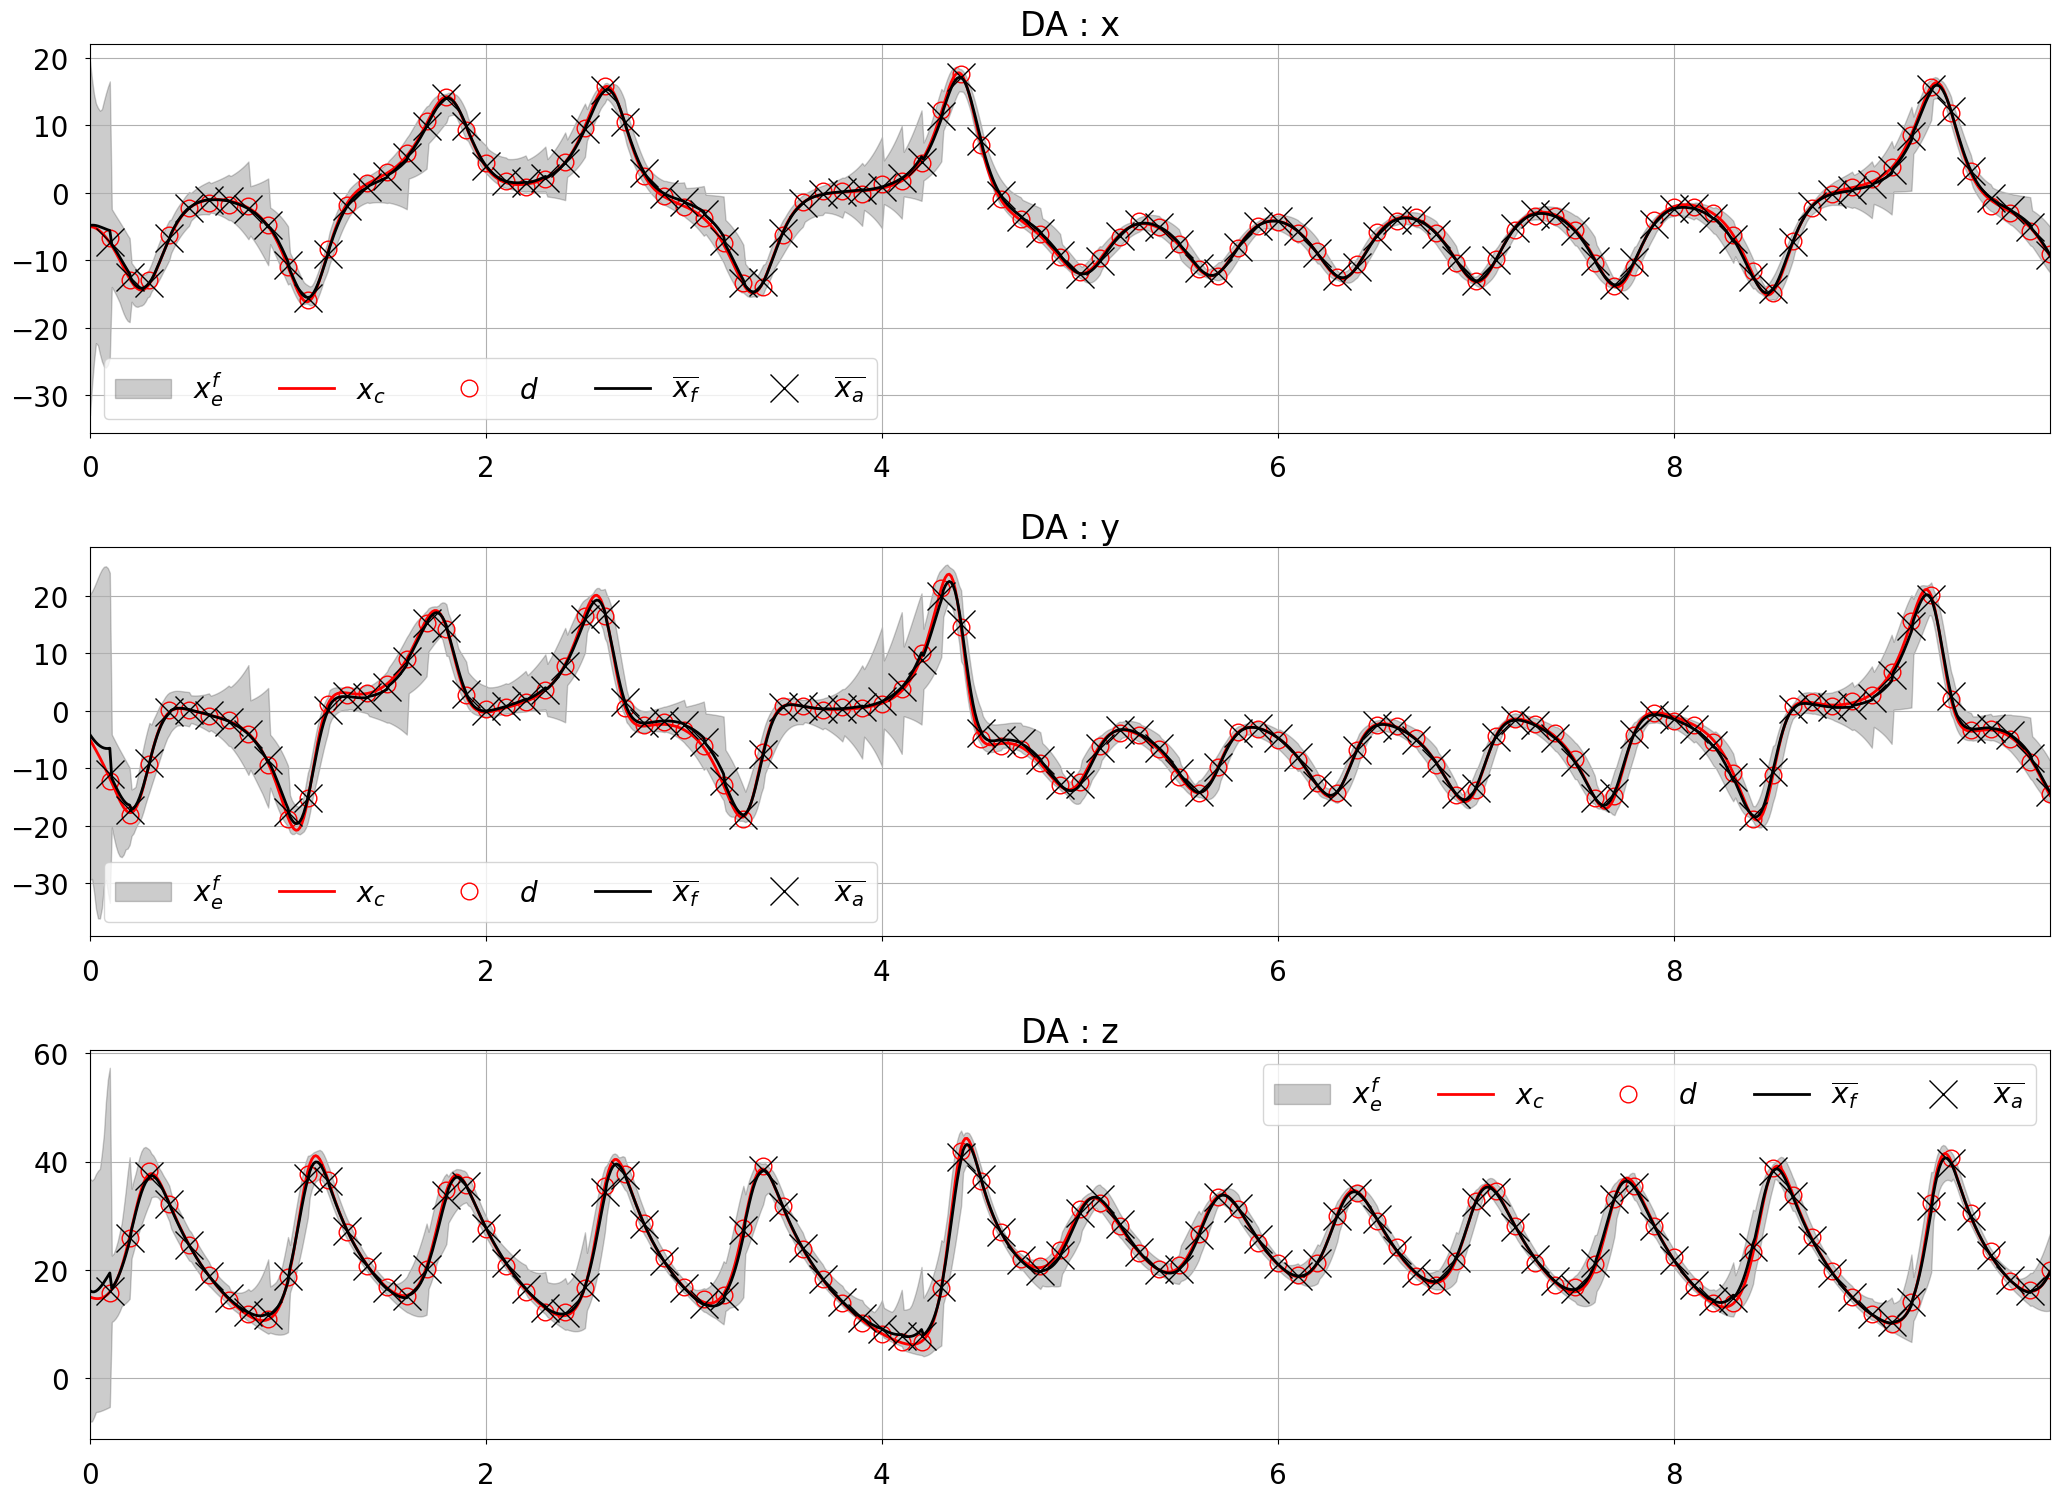

In [17]:
plot_kf_state(enkf_L63_observe_all_states, state_indices=[0,1,2], state_index_names=['x','y','z'])

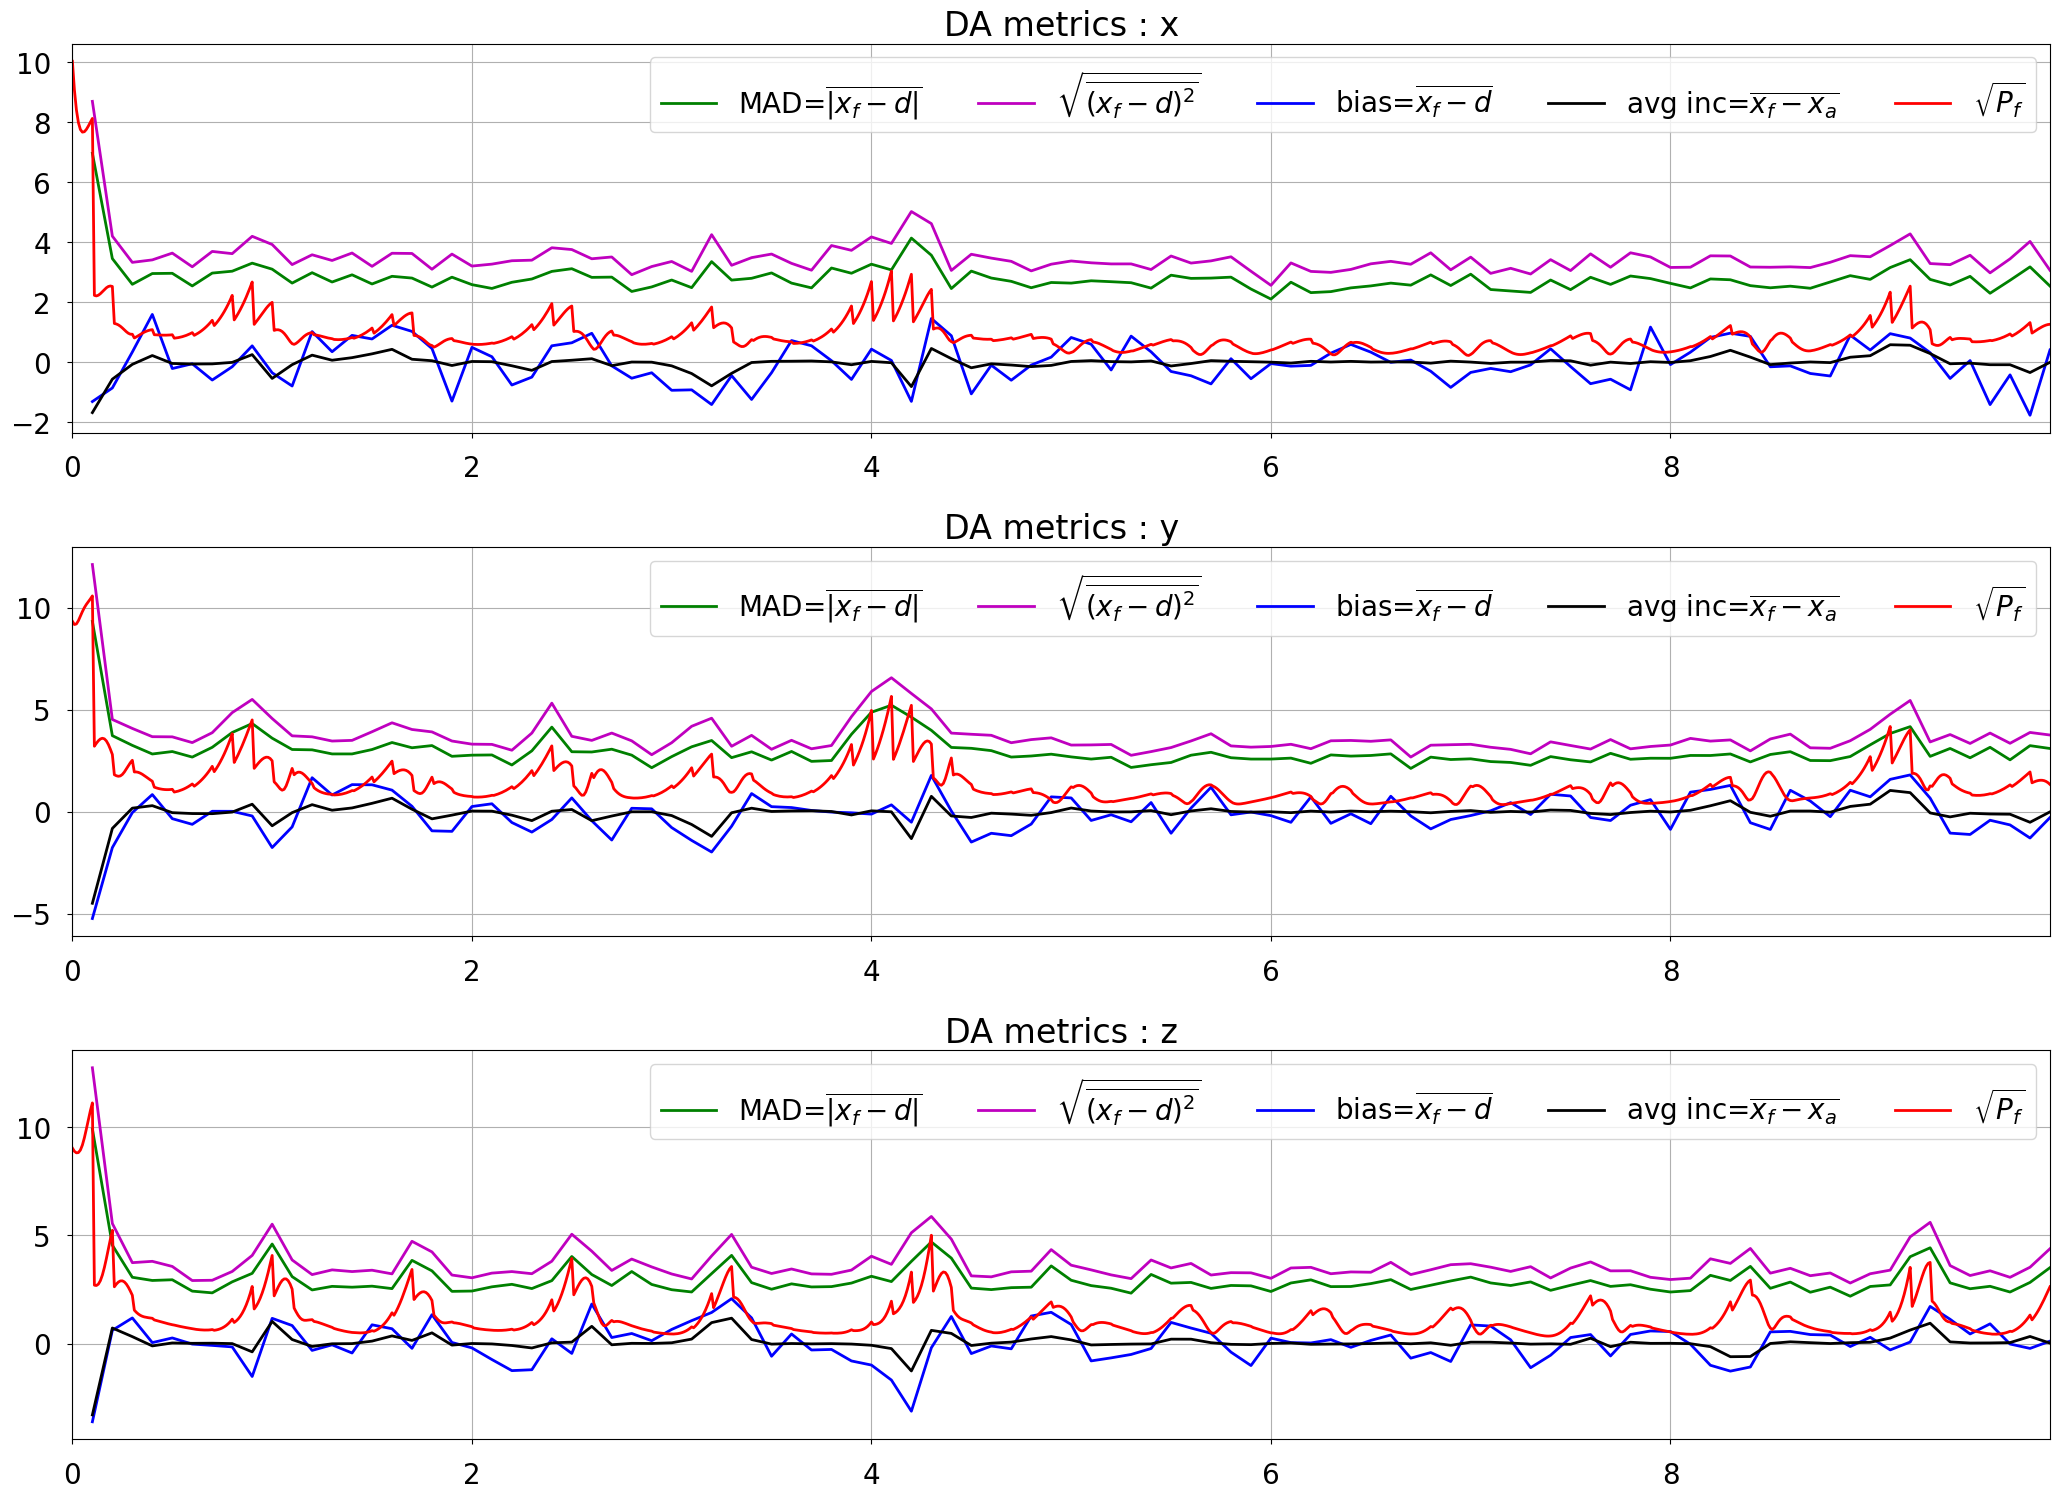

In [18]:
plot_kf_statistics(enkf_L63_observe_all_states, state_indices=[0,1,2], state_index_names=['x','y','z'])

# State estimation observing only the first state

In [19]:
# Control settings
num_time_steps    = 1000
control_model     = Lorenz1963(num_time_steps=num_time_steps)

# Forecast settings
num_members       = 100
IC_std            = np.ones(control_model.num_states)*1.0e1    # Initial condition error covariance
forecast_ensemble = initialise_ensemble(control_model, num_members, IC_std)

# EnKF settings
kf_type           = 'EnKF'
forecast_window   = 10
num_obs           = 1 # observe only first state
Q                 = np.eye(control_model.num_states)*1.0e-1    # Process error covariance in the forecasts
D_obs             = np.eye(num_obs)*1.0e-1   # Actual measurement error covariance
D                 = D_obs*100    # Estimated measurement error covariance

enkf_L63_observe_first_state = EnsembleKalmanFilter(control_model, forecast_ensemble, forecast_window=forecast_window, kf_type=kf_type, H=None, Q=Q, D_obs=D_obs, D=D)

Initialising state


In [20]:
enkf_L63_observe_first_state.do_assimilation()

Processing cycle 1 of 99
Processing cycle 2 of 99
Processing cycle 3 of 99
Processing cycle 4 of 99
Processing cycle 5 of 99
Processing cycle 6 of 99
Processing cycle 7 of 99
Processing cycle 8 of 99
Processing cycle 9 of 99
Processing cycle 10 of 99
Processing cycle 11 of 99
Processing cycle 12 of 99
Processing cycle 13 of 99
Processing cycle 14 of 99
Processing cycle 15 of 99
Processing cycle 16 of 99
Processing cycle 17 of 99
Processing cycle 18 of 99
Processing cycle 19 of 99
Processing cycle 20 of 99
Processing cycle 21 of 99
Processing cycle 22 of 99
Processing cycle 23 of 99
Processing cycle 24 of 99
Processing cycle 25 of 99
Processing cycle 26 of 99
Processing cycle 27 of 99
Processing cycle 28 of 99
Processing cycle 29 of 99
Processing cycle 30 of 99
Processing cycle 31 of 99
Processing cycle 32 of 99
Processing cycle 33 of 99
Processing cycle 34 of 99
Processing cycle 35 of 99
Processing cycle 36 of 99
Processing cycle 37 of 99
Processing cycle 38 of 99
Processing cycle 39 o

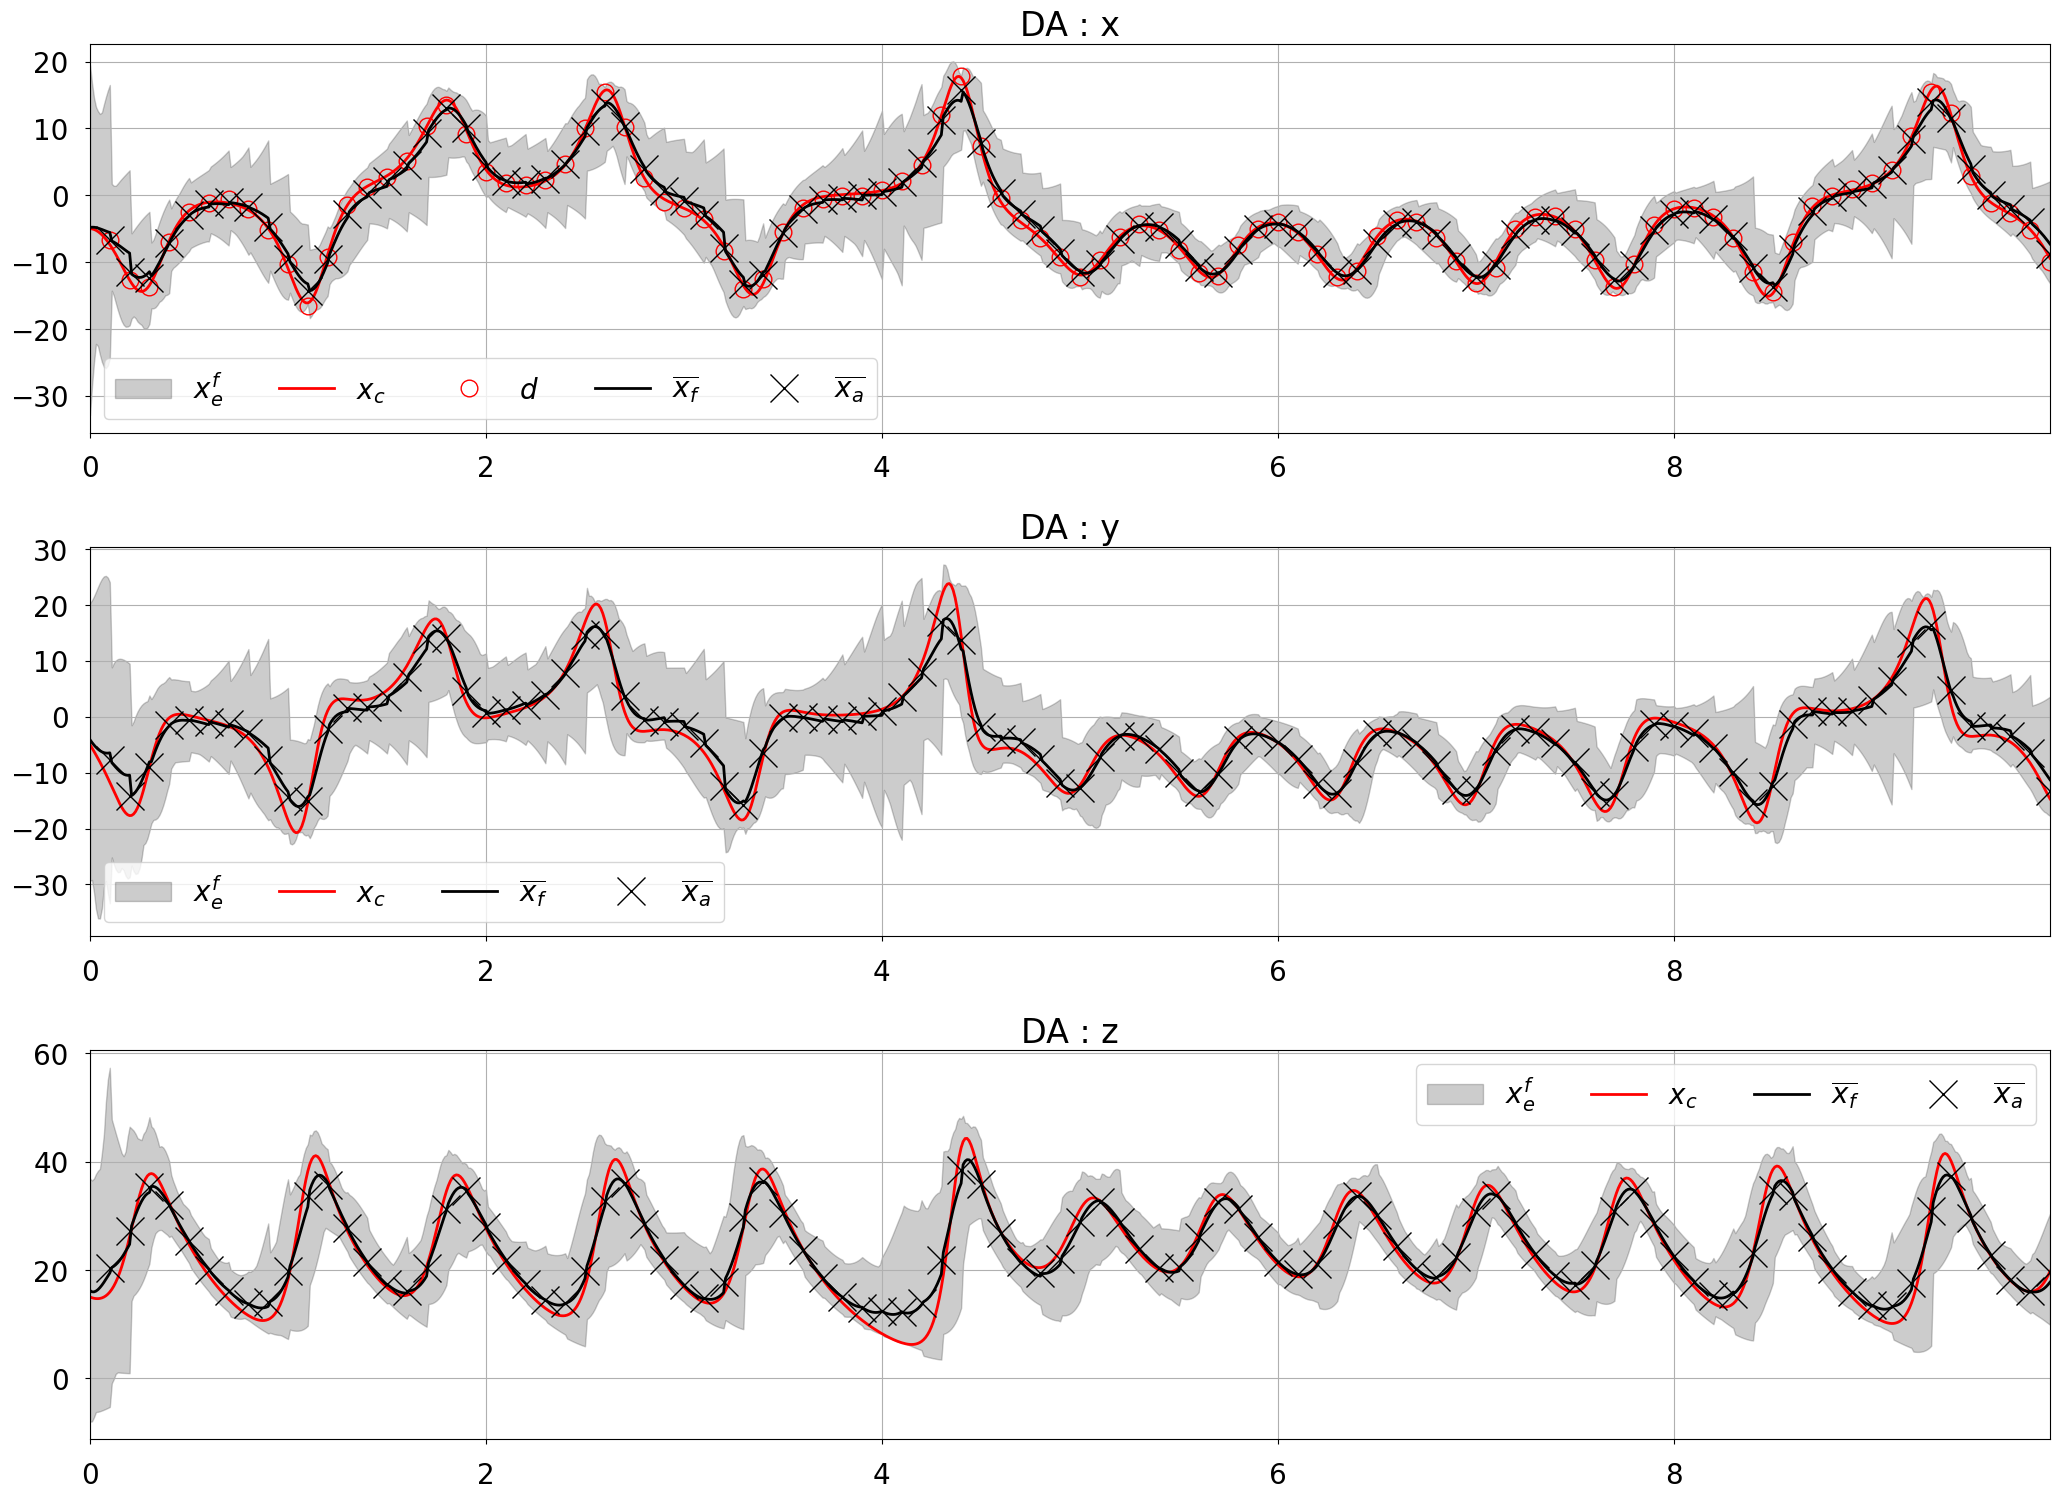

In [21]:
plot_kf_state(enkf_L63_observe_first_state, state_indices=[0,1,2], state_index_names=['x','y','z'])

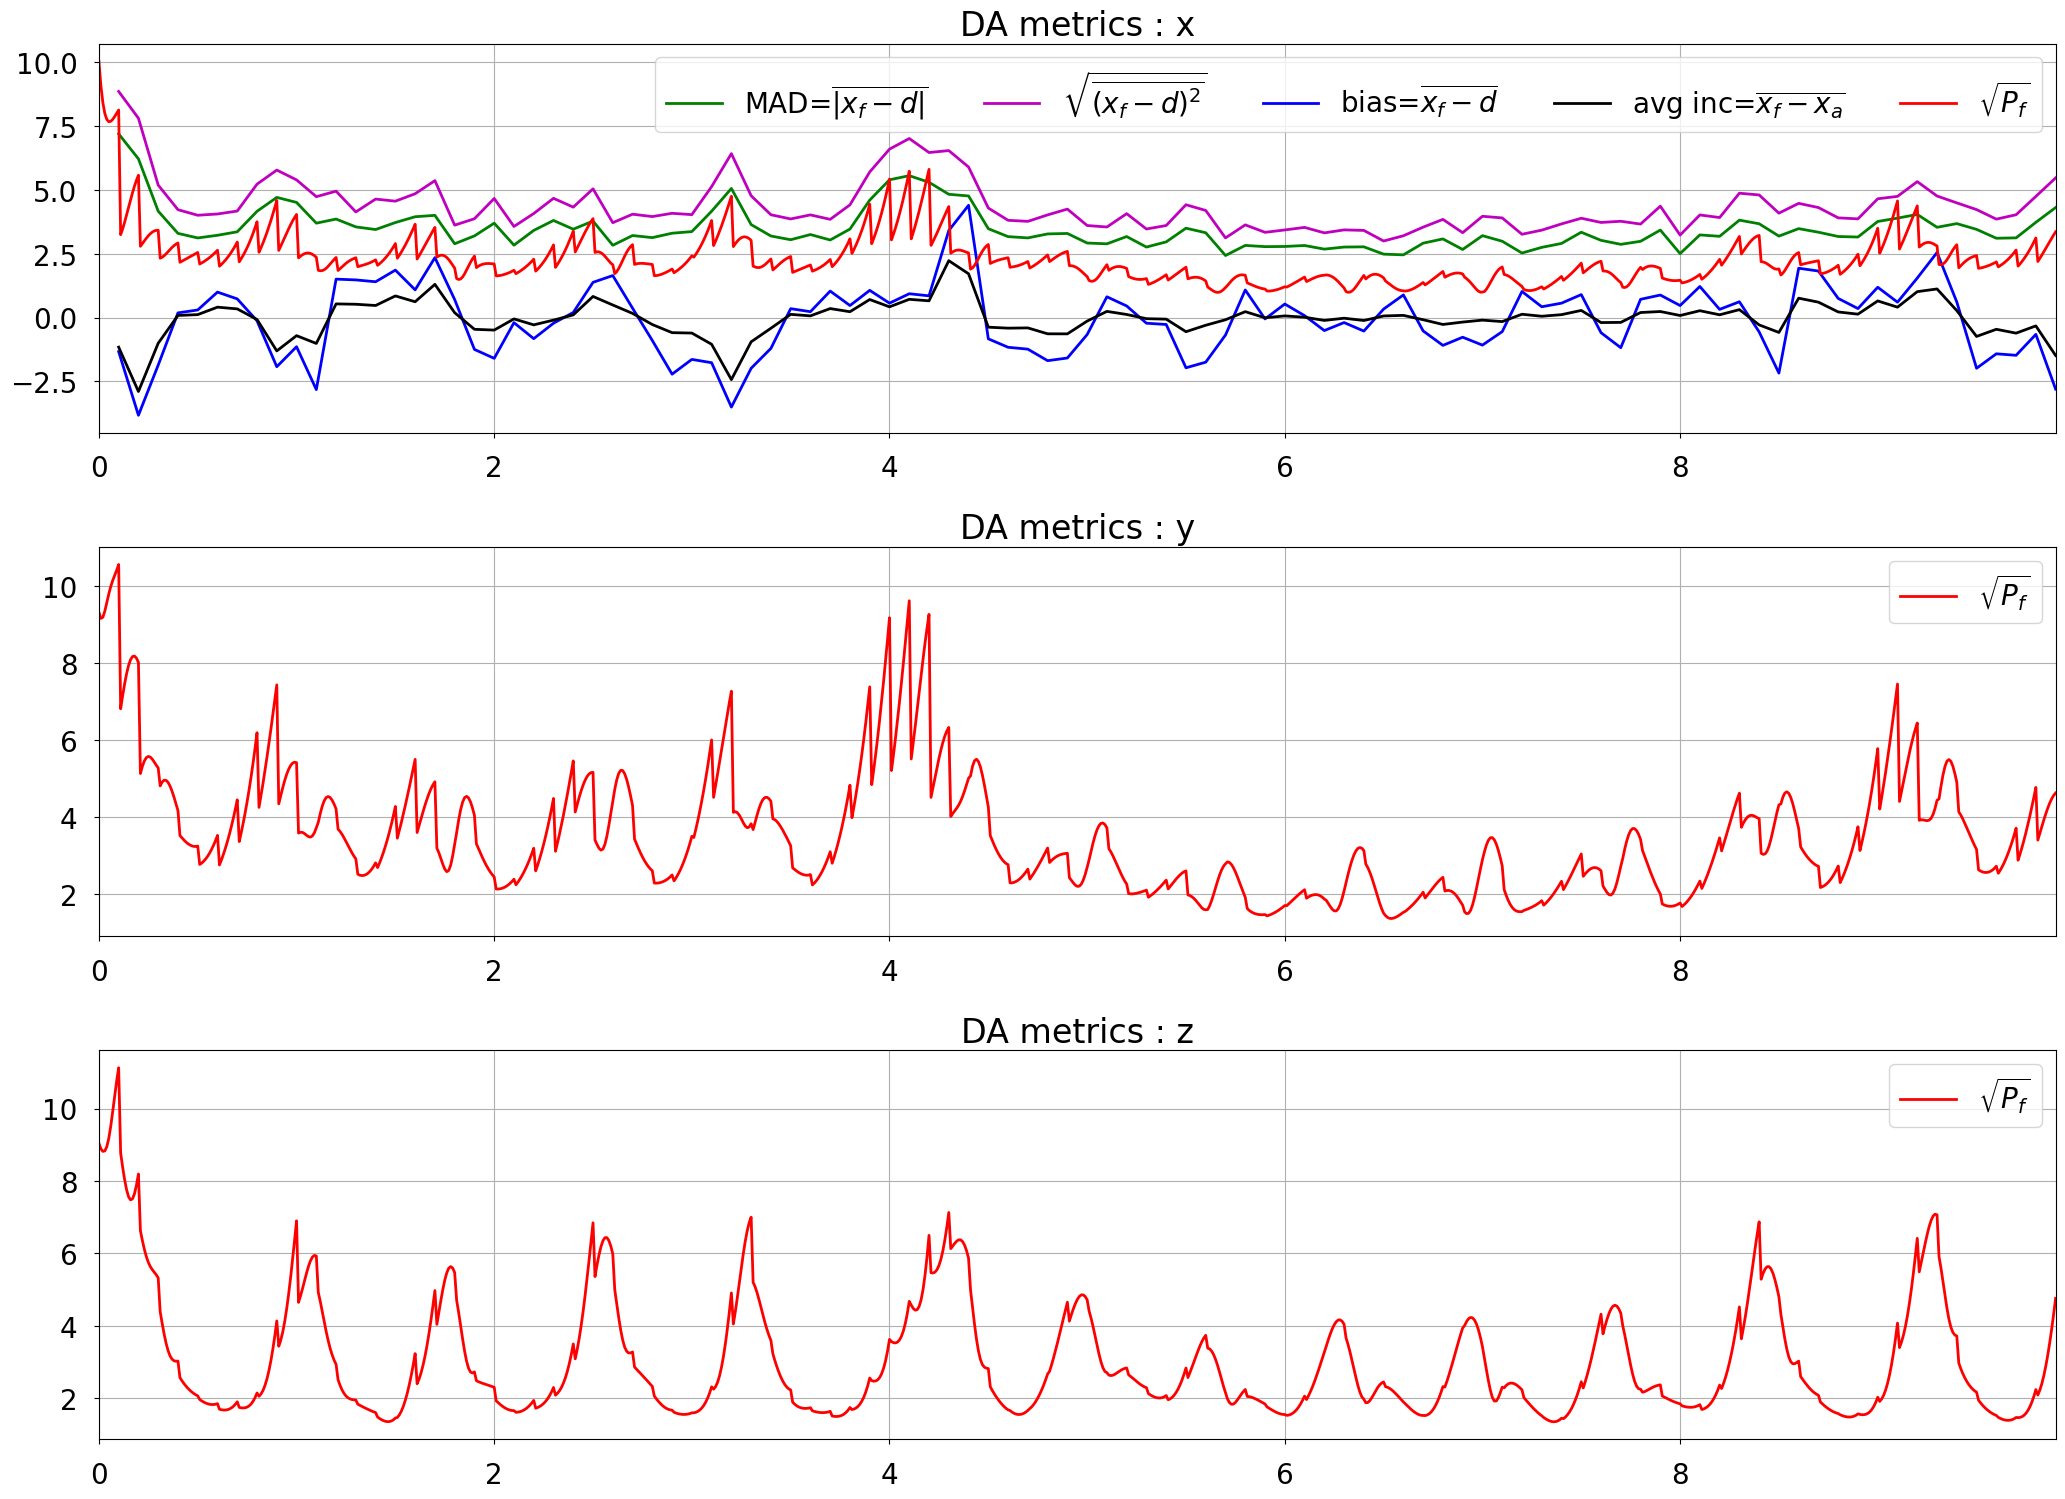

In [22]:
plot_kf_statistics(enkf_L63_observe_first_state, state_indices=[0,1,2], state_index_names=['x','y','z'])

# State and parameter estimation observing all states

In [49]:
# Control settings
num_time_steps    = 1000
control_model     = Lorenz1963(num_time_steps=num_time_steps)

# Forecast settings
num_members       = 100
IC_std            = np.ones(control_model.num_states)*1.0e1   # Initial condition error covariance
num_parameters    = 1                                         # Number of parmeters to estimate
param_avg         = np.ones((num_parameters))*20
param_std         = np.ones((num_parameters))*3
forecast_ensemble = initialise_ensemble(control_model, num_members, IC_std, param_avg=param_avg, param_std=param_std)

# EnKF settings
kf_type           = 'EnKF'
forecast_window   = 10
num_obs           = control_model.num_states                  # observe all states
Q                 = np.eye(control_model.num_states)*1.0e-1   # Process error covariance in the forecasts
D_obs             = np.eye(num_obs)*1.0e-1                    # Actual measurement error covariance
D                 = D_obs*100                                 # Estimated measurement error covariance
H                 = np.array(np.eye(num_obs, control_model.num_states+num_parameters), dtype=float)
sigma             = np.concatenate((np.zeros(control_model.num_states), np.ones(num_parameters)))*1.0  # stochastic noise component
alpha             = np.concatenate((np.zeros(control_model.num_states), np.ones(num_parameters)))*0.9  # correlated noise component

enkf_L63_observe_all_states_param = EnsembleKalmanFilter(control_model, forecast_ensemble, forecast_window=forecast_window, kf_type=kf_type, \
                                                         H=H, Q=Q, D_obs=D_obs, D=D, \
                                                         num_parameters=num_parameters, sigma=sigma, alpha=alpha)

Initialising state


In [50]:
enkf_L63_observe_all_states_param.do_assimilation()

Processing cycle 1 of 99
Processing cycle 2 of 99
Processing cycle 3 of 99
Processing cycle 4 of 99
Processing cycle 5 of 99
Processing cycle 6 of 99
Processing cycle 7 of 99
Processing cycle 8 of 99
Processing cycle 9 of 99
Processing cycle 10 of 99
Processing cycle 11 of 99
Processing cycle 12 of 99
Processing cycle 13 of 99
Processing cycle 14 of 99
Processing cycle 15 of 99
Processing cycle 16 of 99
Processing cycle 17 of 99
Processing cycle 18 of 99
Processing cycle 19 of 99
Processing cycle 20 of 99
Processing cycle 21 of 99
Processing cycle 22 of 99
Processing cycle 23 of 99
Processing cycle 24 of 99
Processing cycle 25 of 99
Processing cycle 26 of 99
Processing cycle 27 of 99
Processing cycle 28 of 99
Processing cycle 29 of 99
Processing cycle 30 of 99
Processing cycle 31 of 99
Processing cycle 32 of 99
Processing cycle 33 of 99
Processing cycle 34 of 99
Processing cycle 35 of 99
Processing cycle 36 of 99
Processing cycle 37 of 99
Processing cycle 38 of 99
Processing cycle 39 o

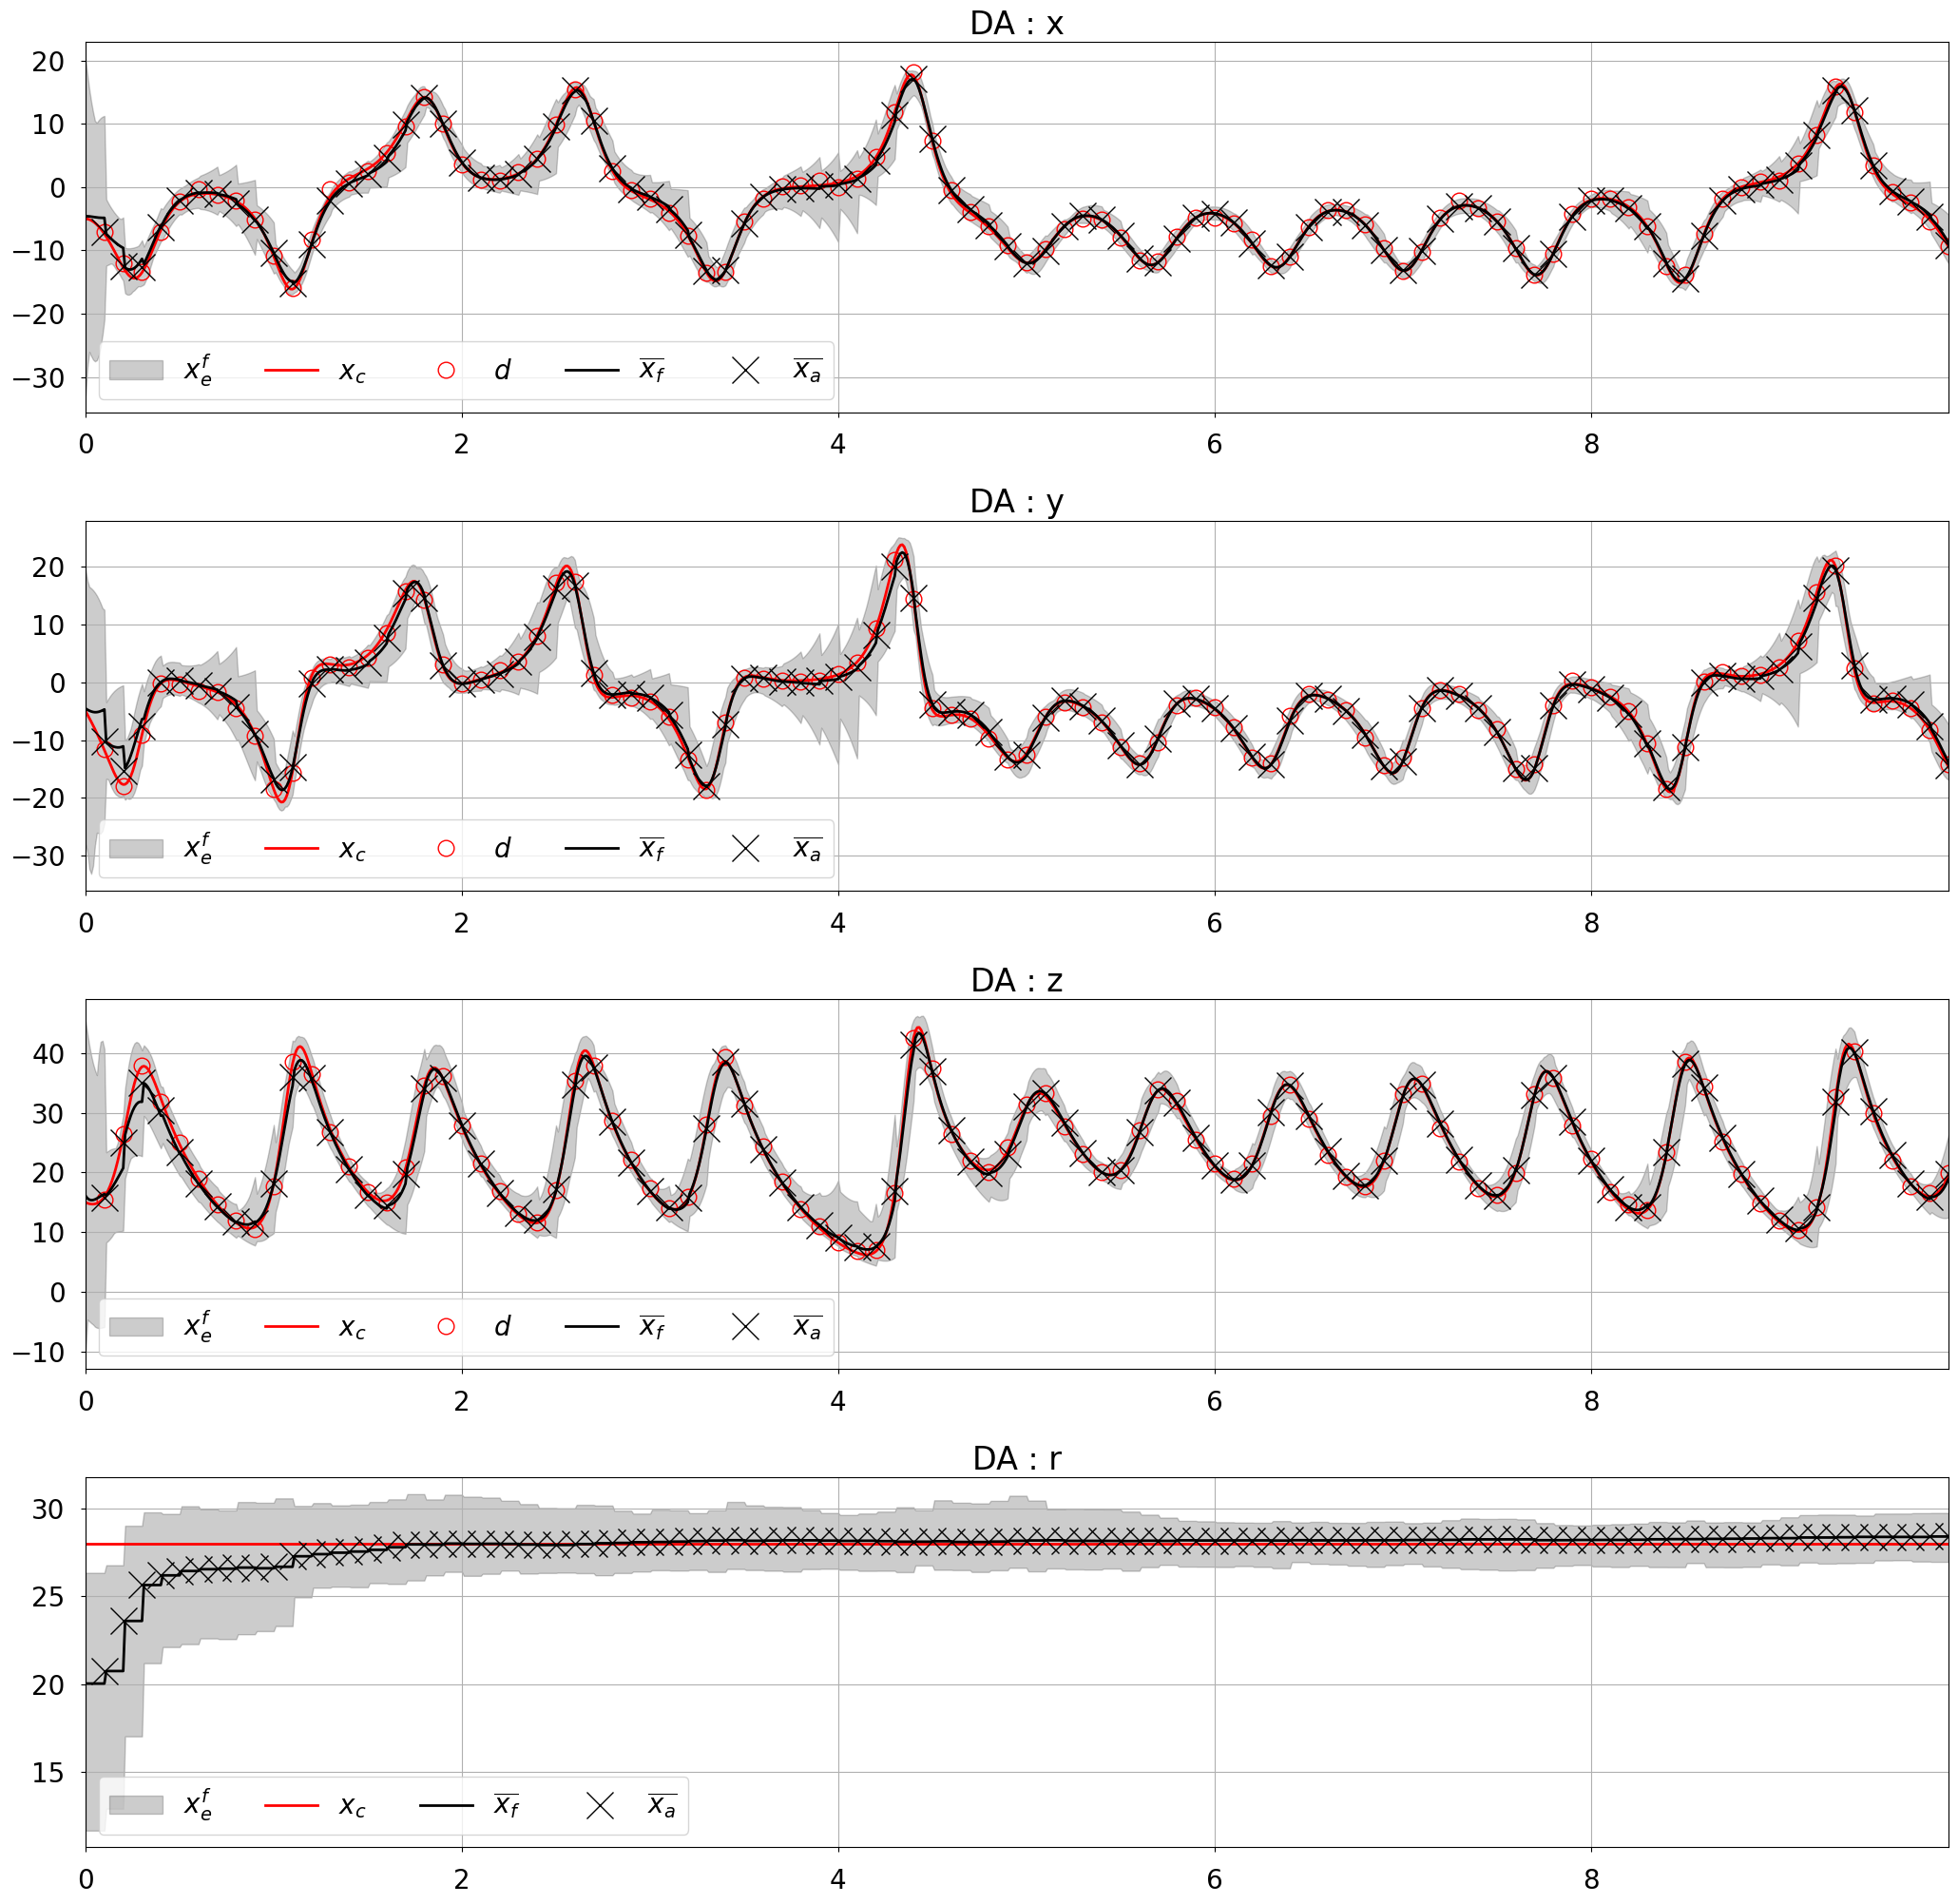

In [51]:
plot_kf_state(enkf_L63_observe_all_states_param, state_indices=[0,1,2,3], state_index_names=['x','y','z','r'])

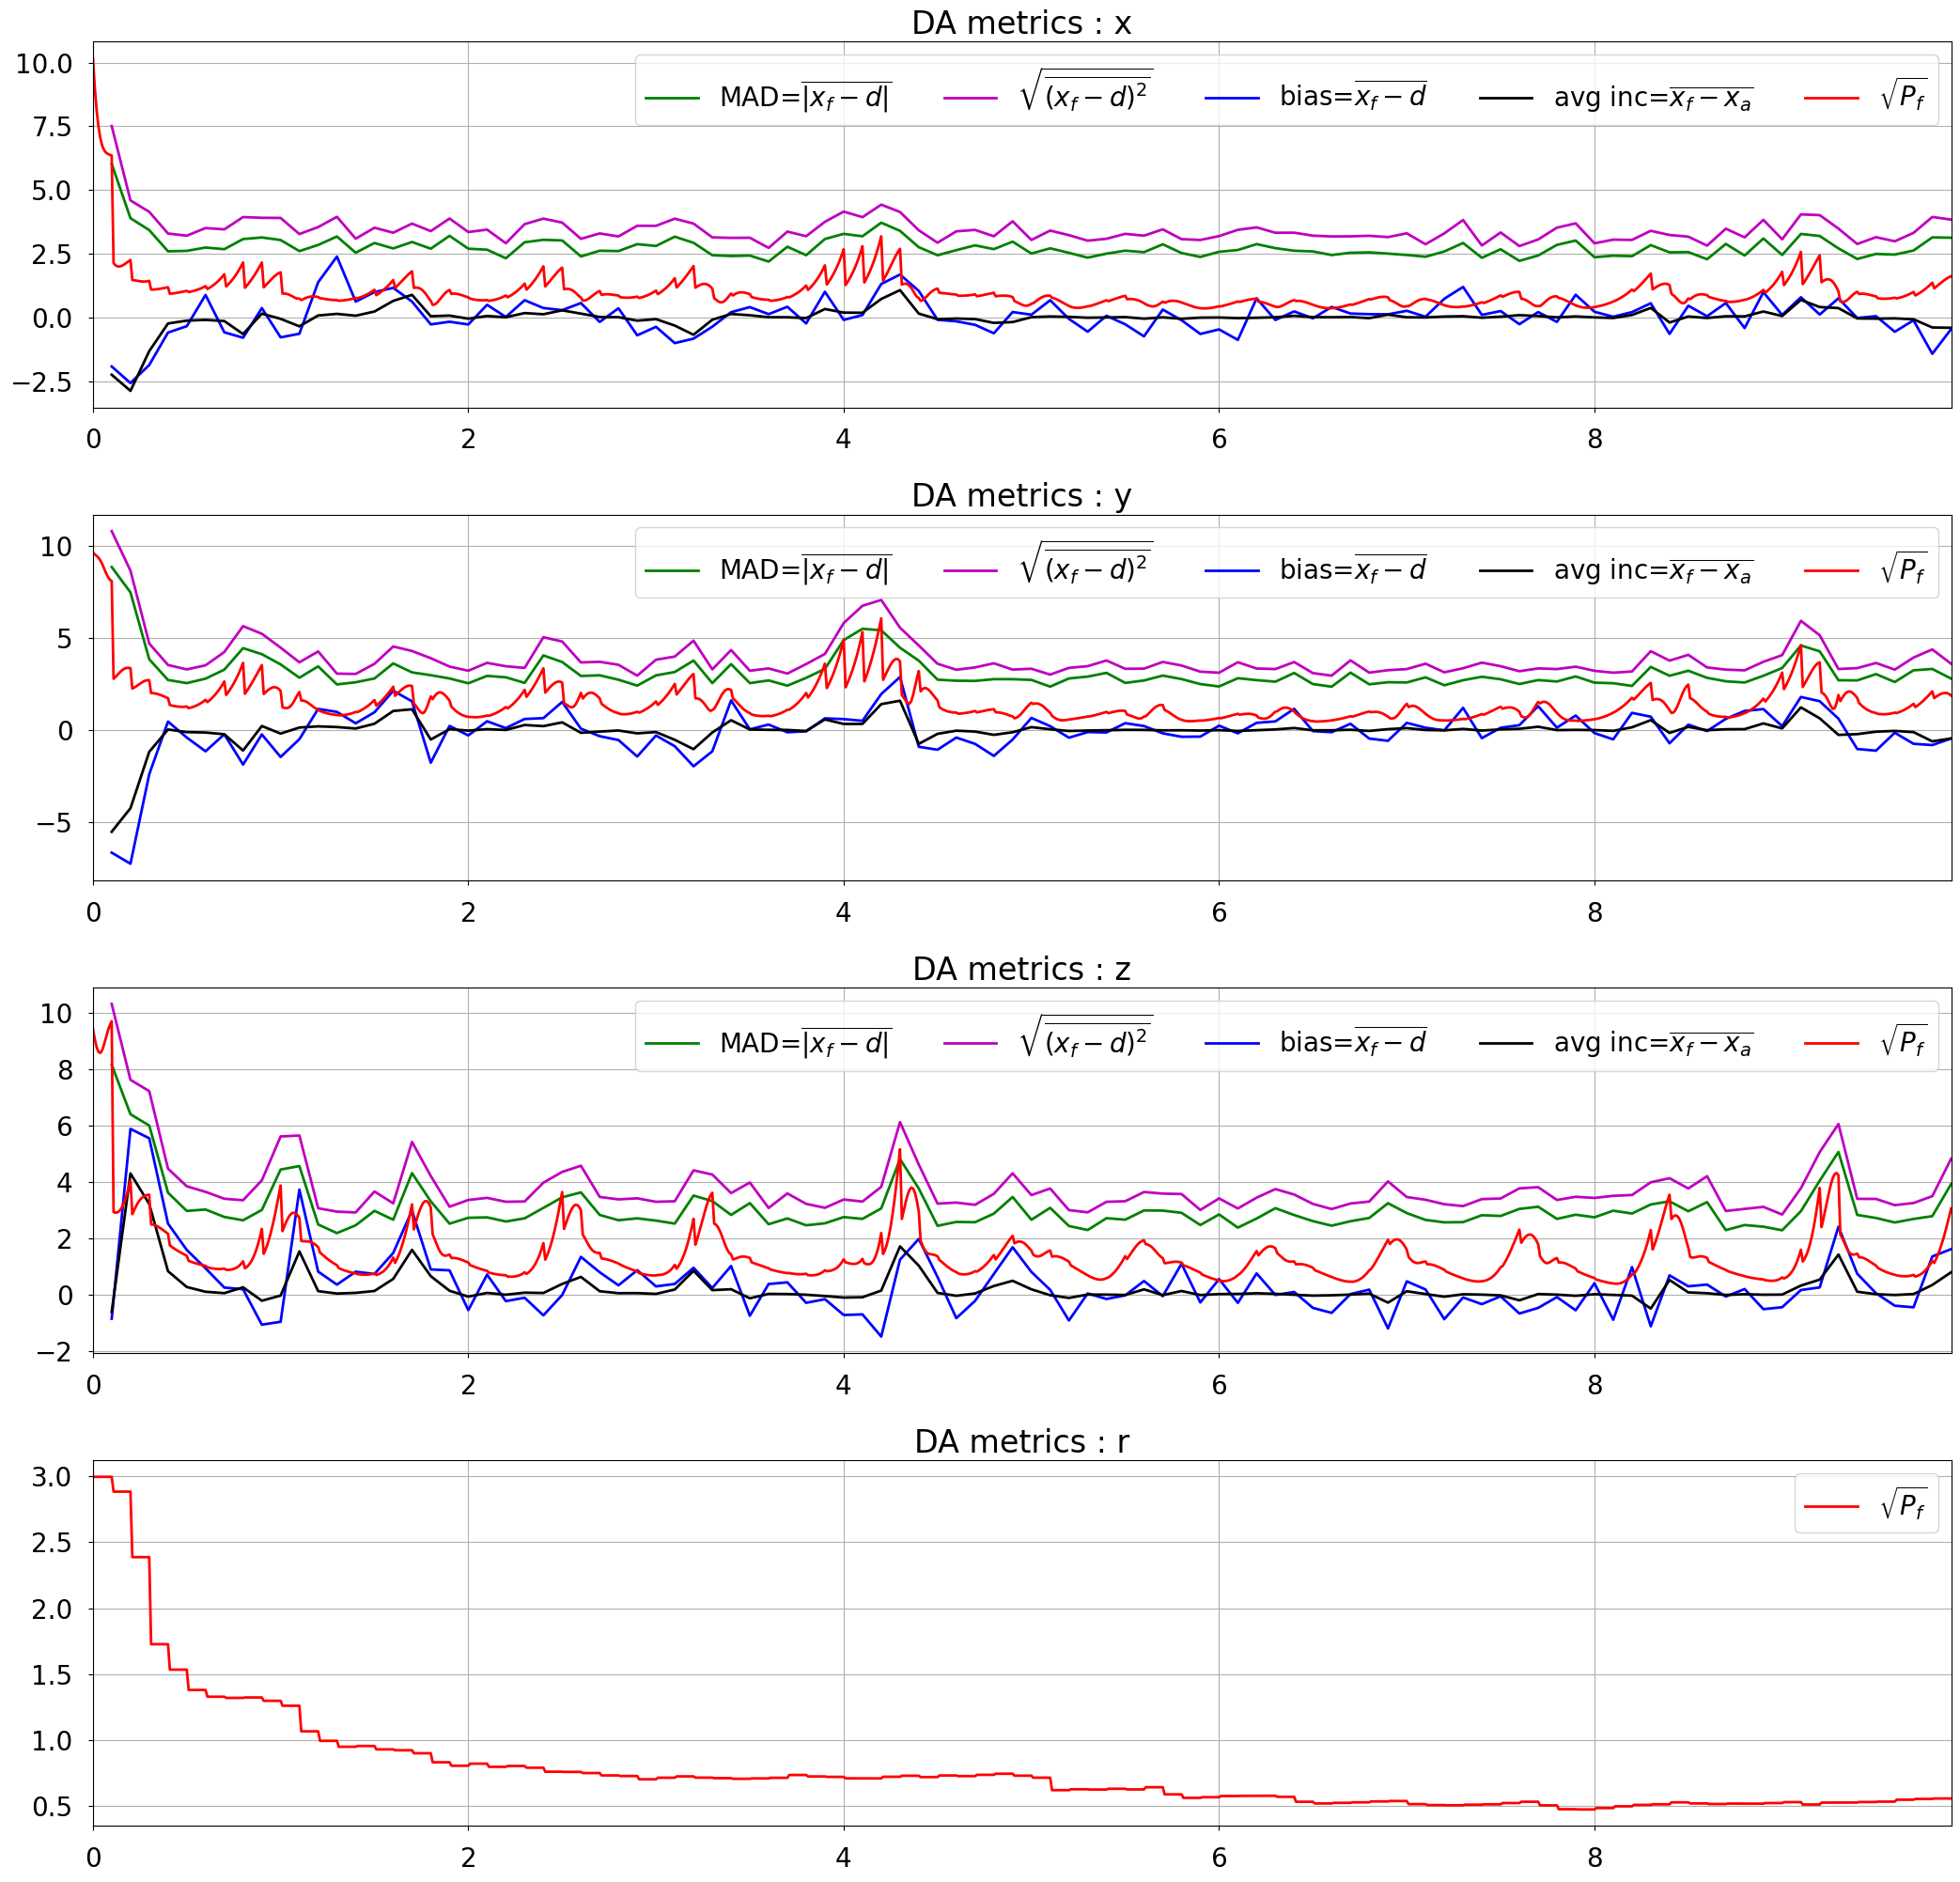

In [52]:
plot_kf_statistics(enkf_L63_observe_all_states_param, state_indices=[0,1,2,3], state_index_names=['x','y','z','r'])